In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False


In [2]:
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
# logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [3]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")  ### I still need the sensor_list for now
dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the runs: \n{dict_of_runs}")
logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

In [4]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (sensor.name != '') and (sensor.name not in unique_names):
                unique_names.append(sensor.name)
logging.info(f"{unique_names}")

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.tempA, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.33°C, fluence: 0, in batch 203, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -

In [5]:

# for ch, sensor in dict_of_batches[this_batch].S[this_scope].channels.items():
#     print(f"{this_scope}, {ch}:", sensor.__dict__)

## USTC
looking specifically at one sensor

In [6]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[]} # 
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if 'USTC' in sensor.name:
                USTC_list.append((batch_object.batch_number, S, ch))
                if batch_object.tempA>0:
                    USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                if batch_object.angle>0:
                    USTC_dict['angled'].append((batch_object.batch_number, S, ch))

logging.info(f"{USTC_list}")

In [7]:
# this_scope = 'S1'
DUTs = [1,2]
### Oscilloscope 1, Channels 2 and 3
print('Room temperature')
for batch_number,S,ch in USTC_dict['room_temp']:
    if verbose:
        print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
        print('sensor:',dict_of_batches[batch_number].S[S].channels[ch].__dict__)
    else: pass

batches_to_study = [(301,'S1'),(408,'S1'),(409,'S1')]  ### with MPC at 2500


Room temperature


DUT_1
DUT_2


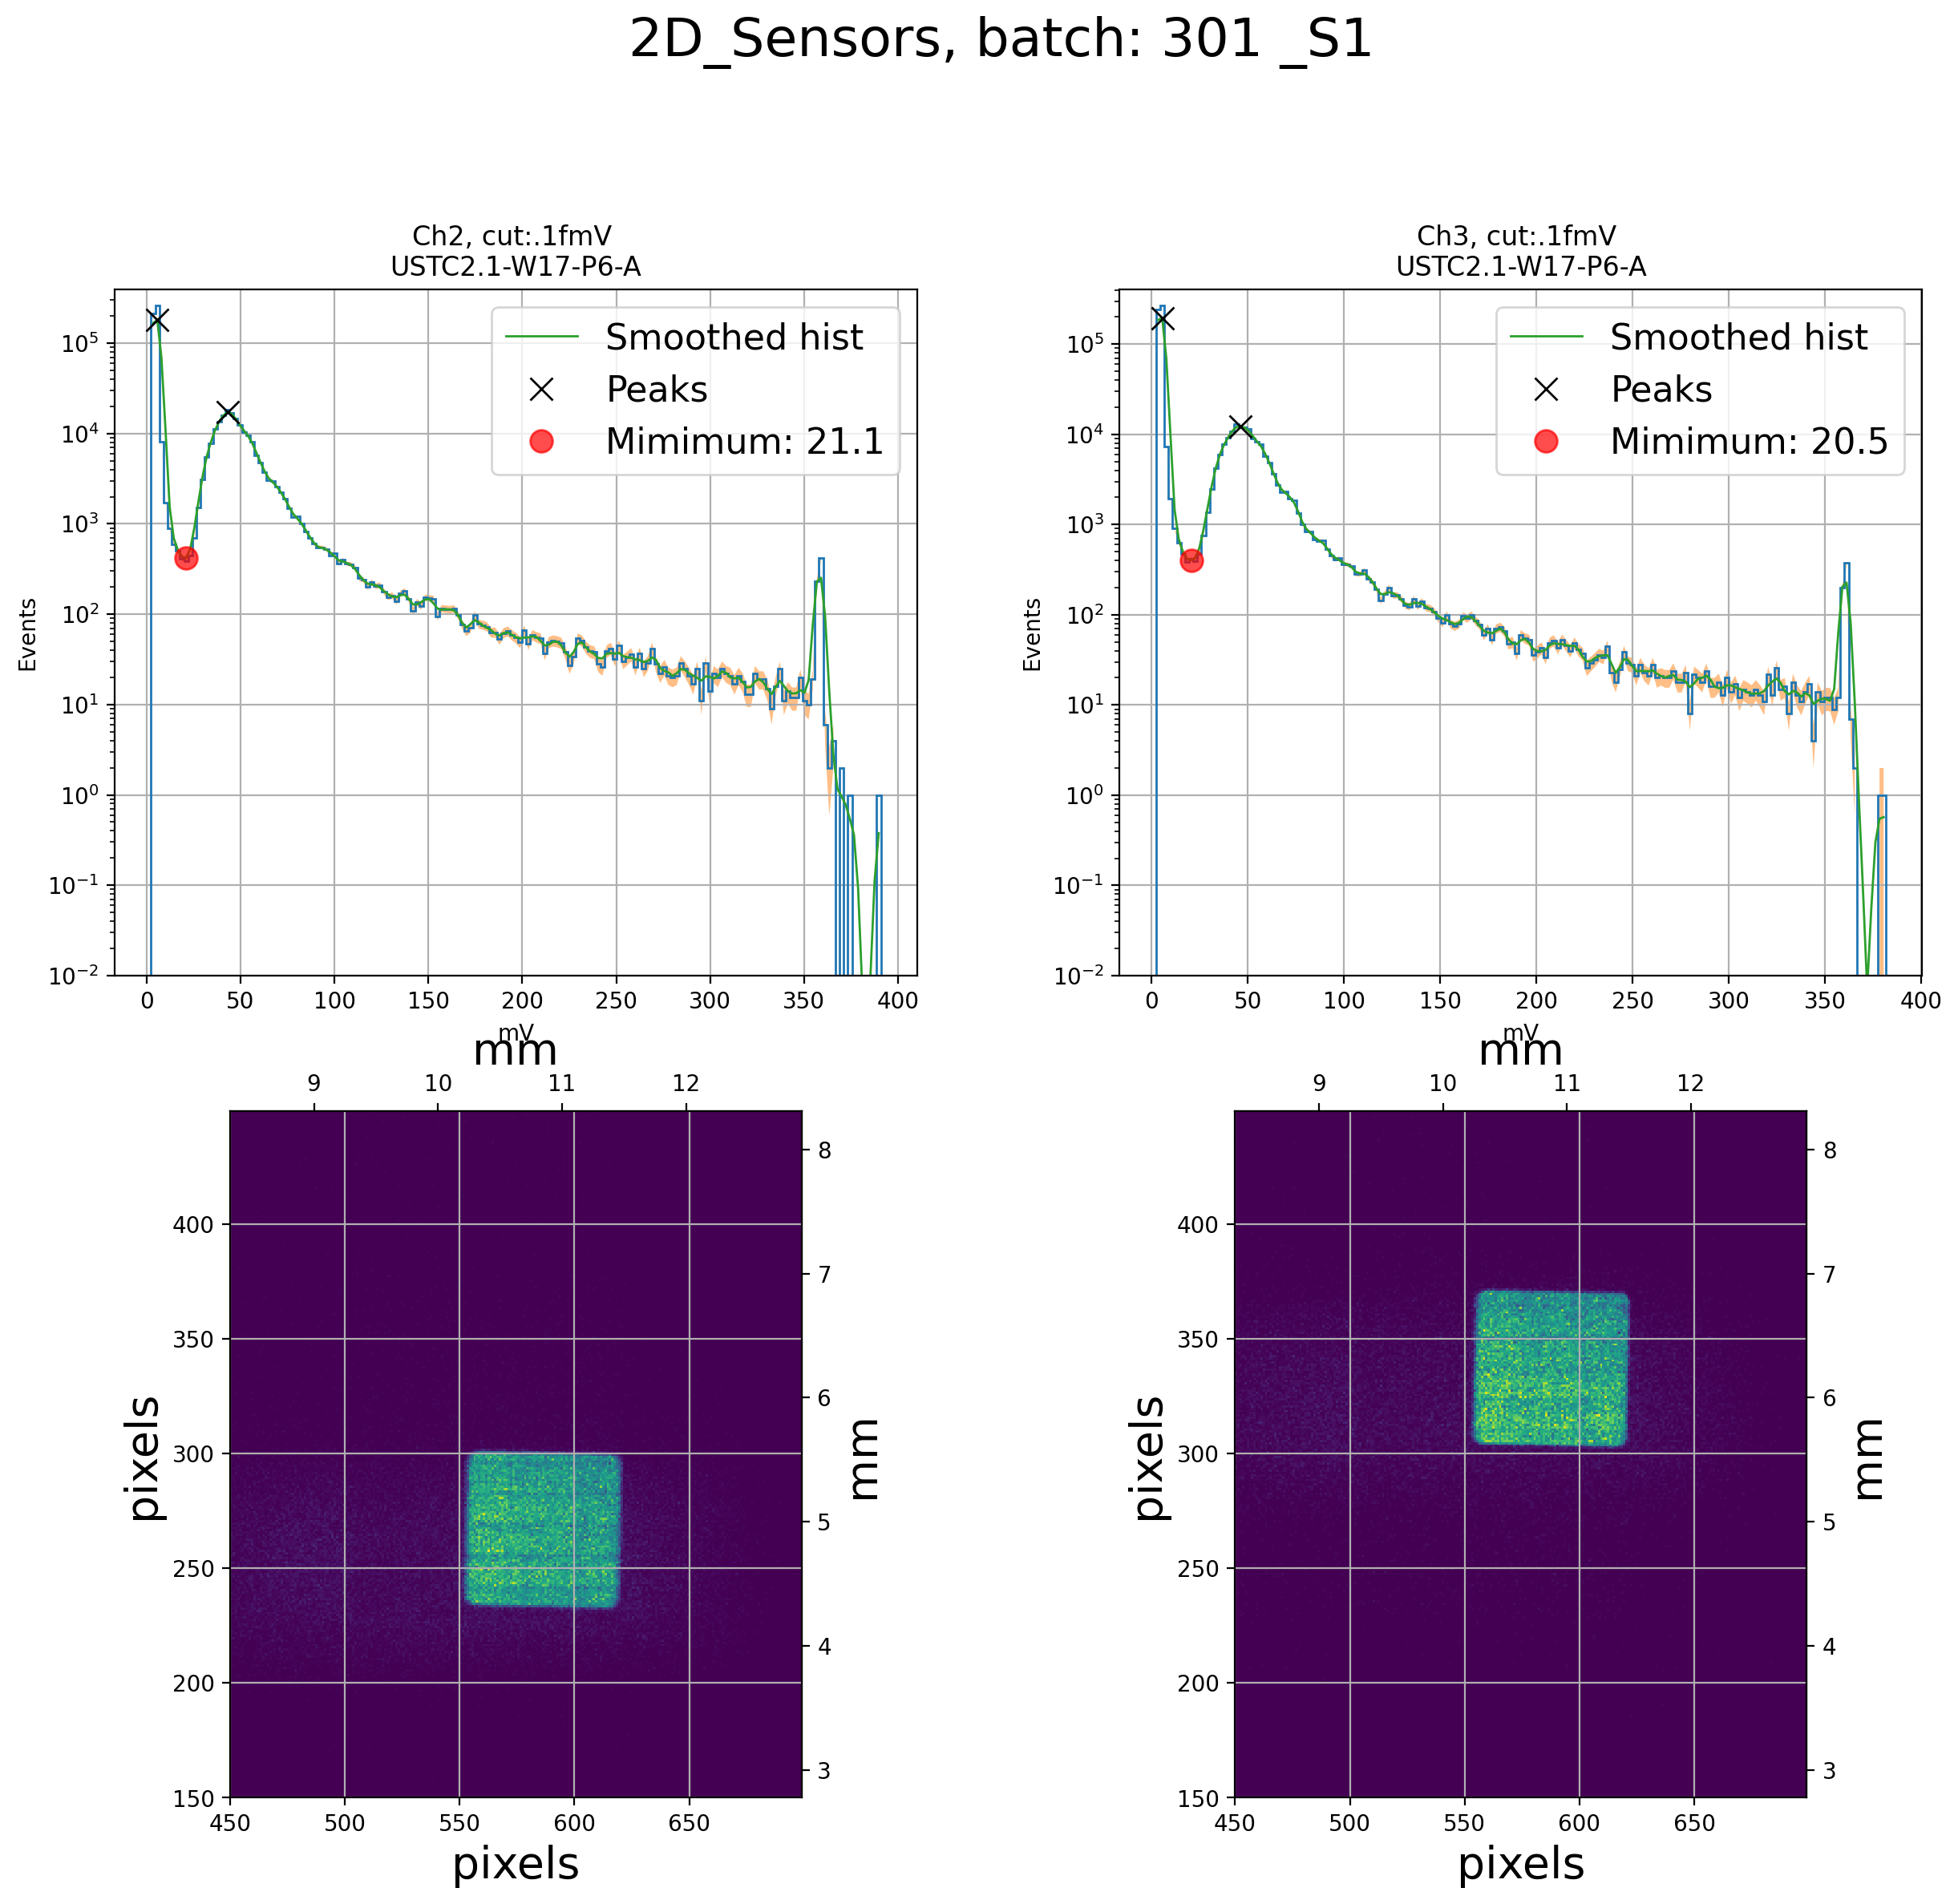

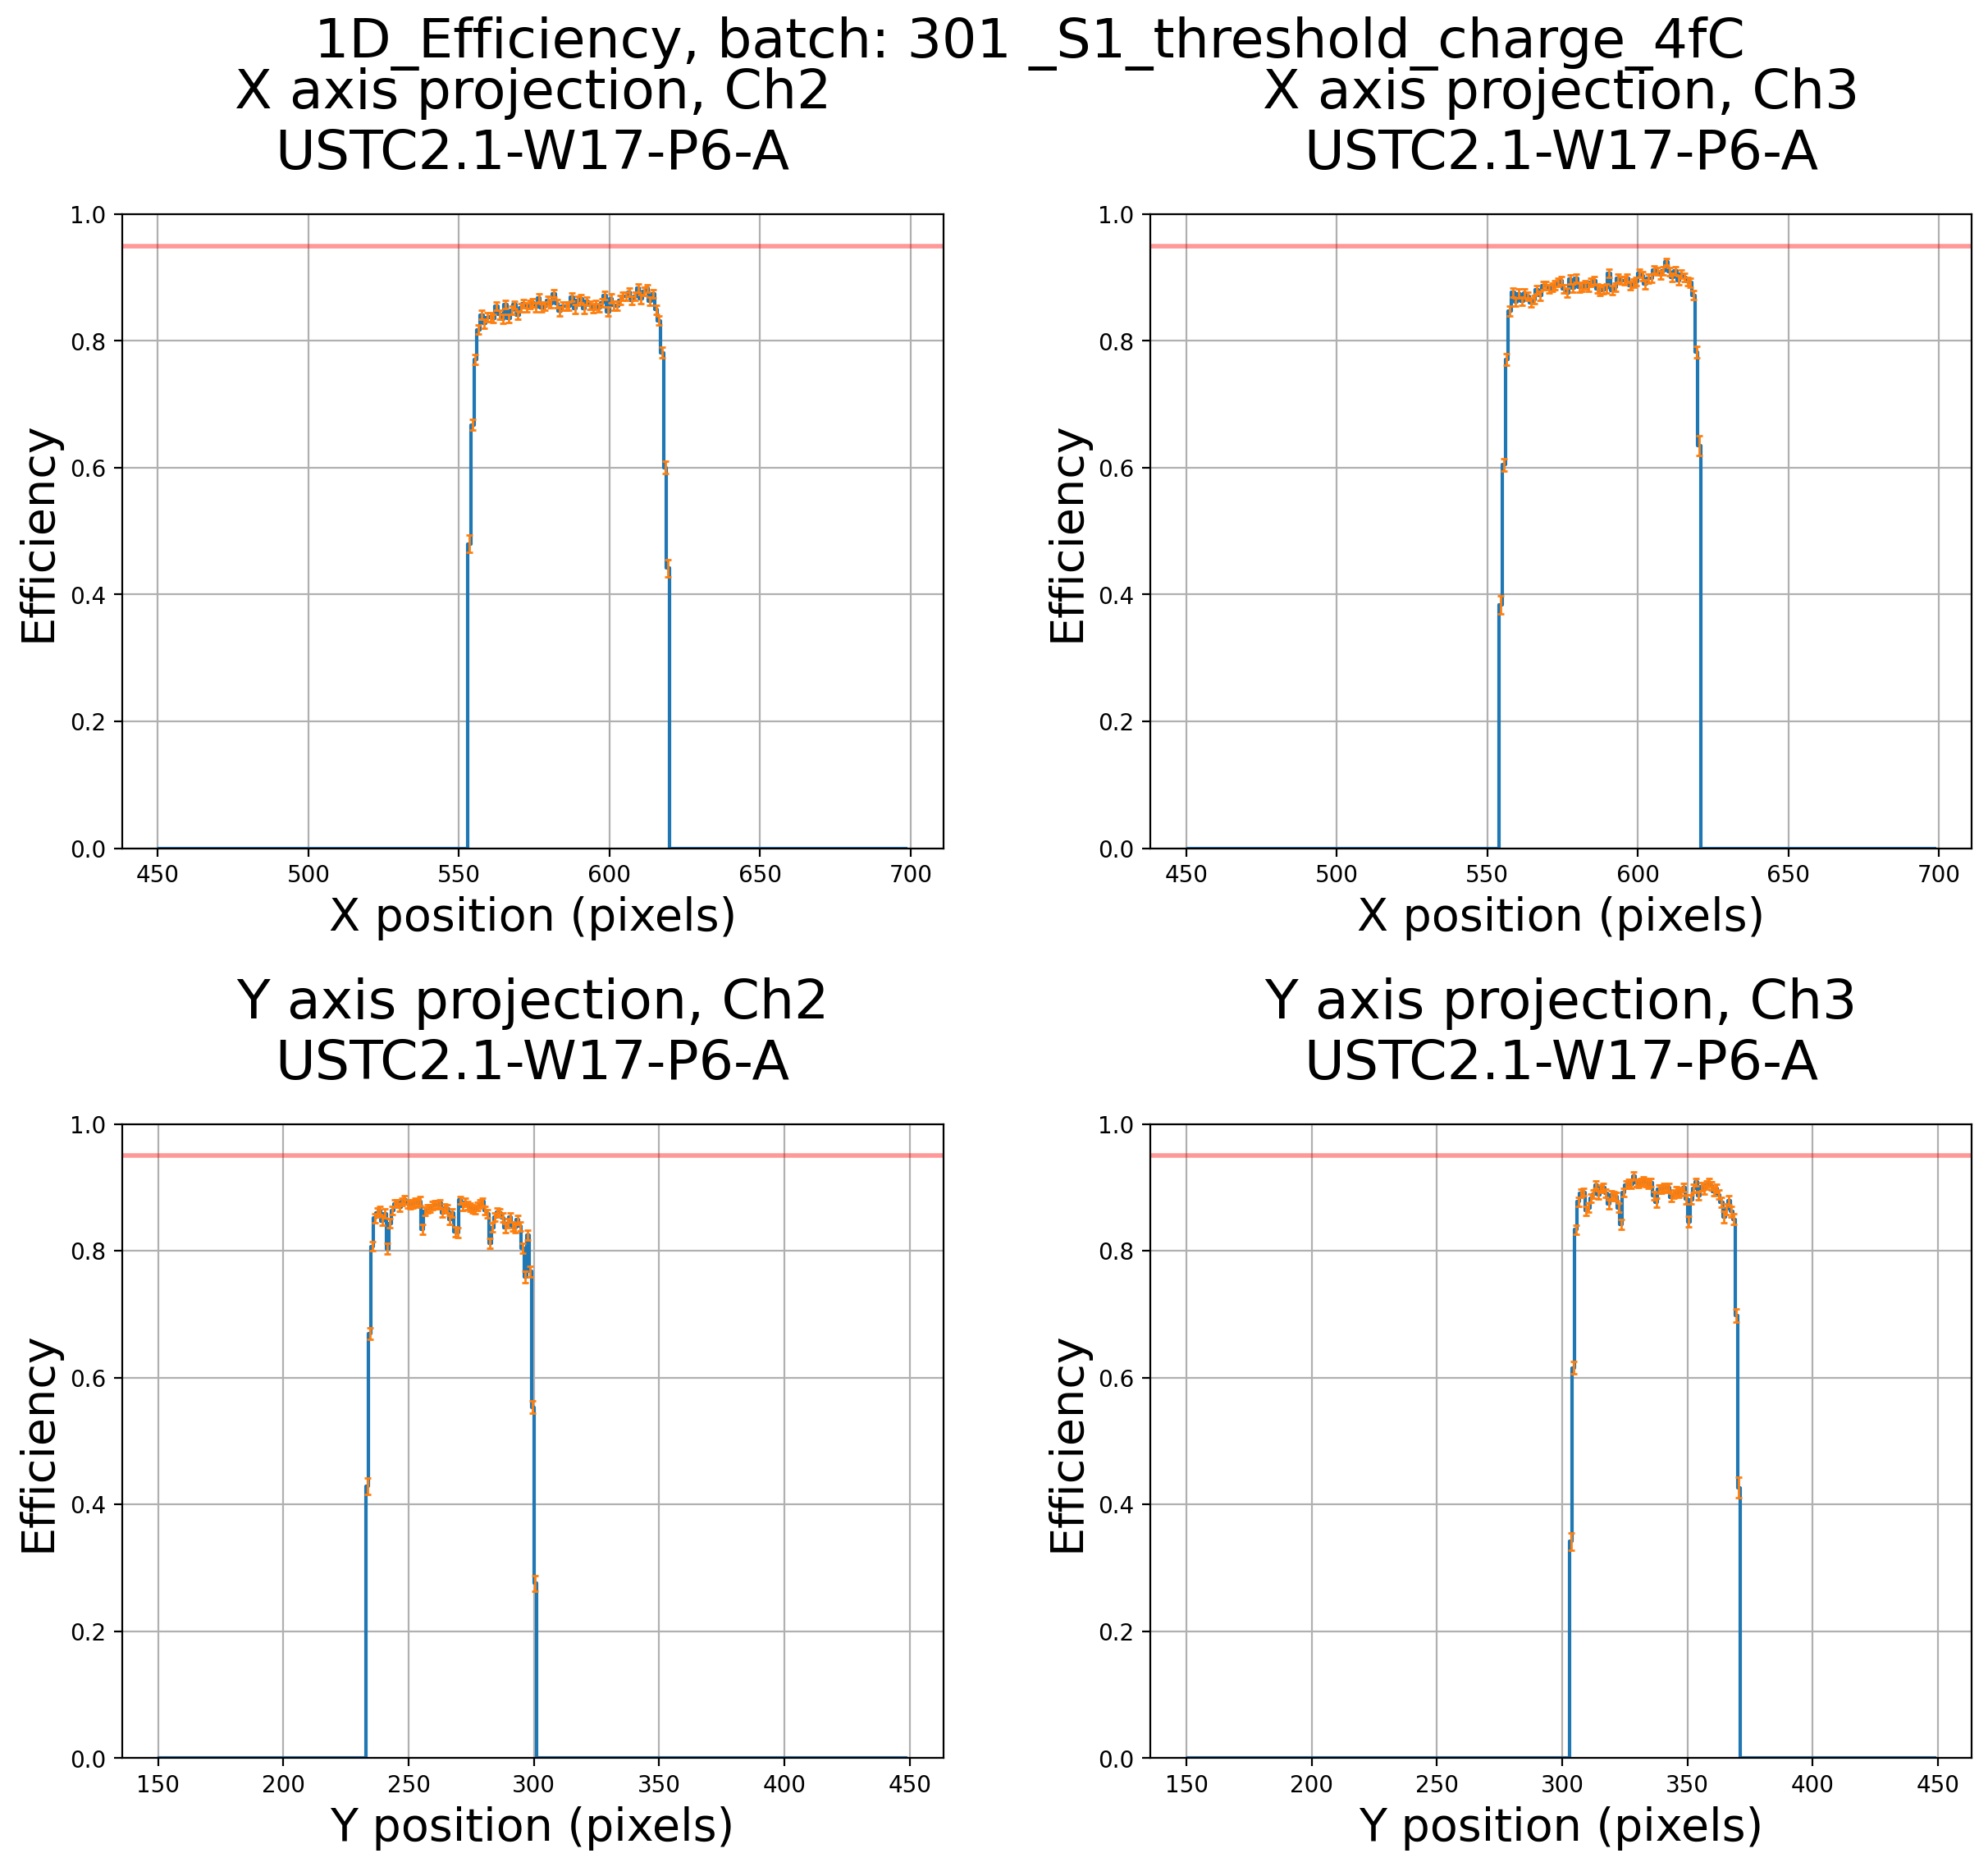

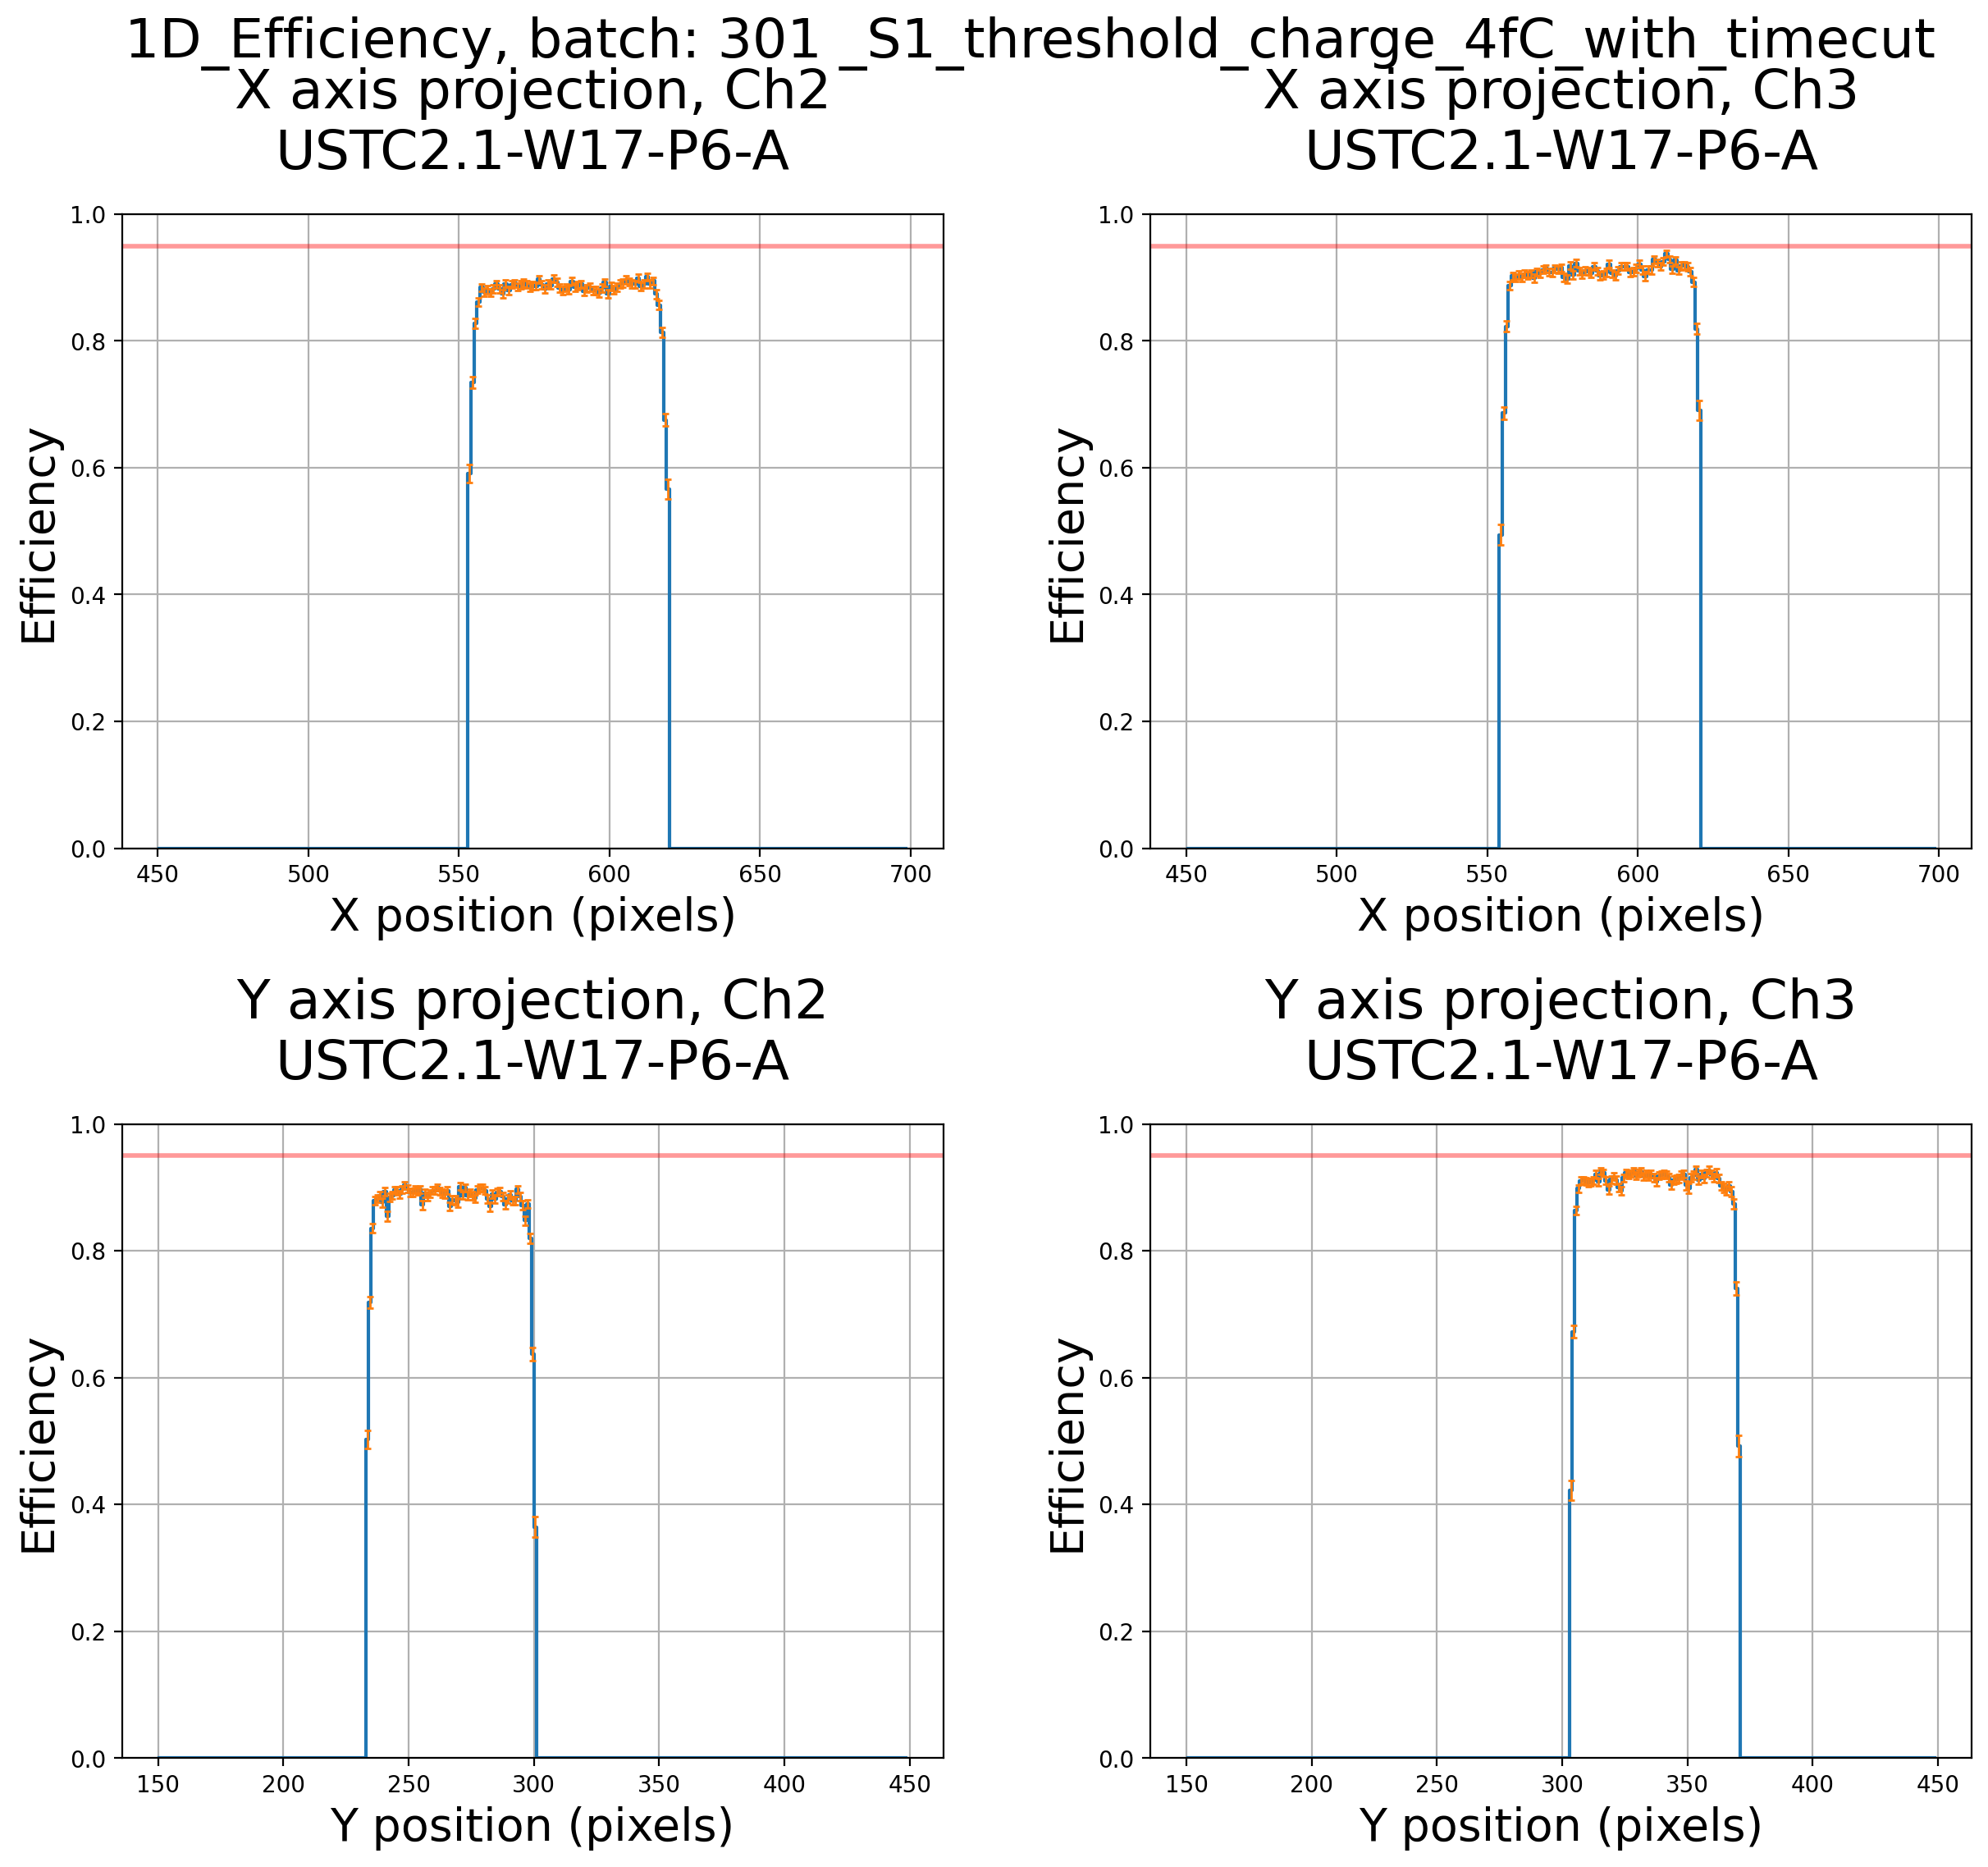

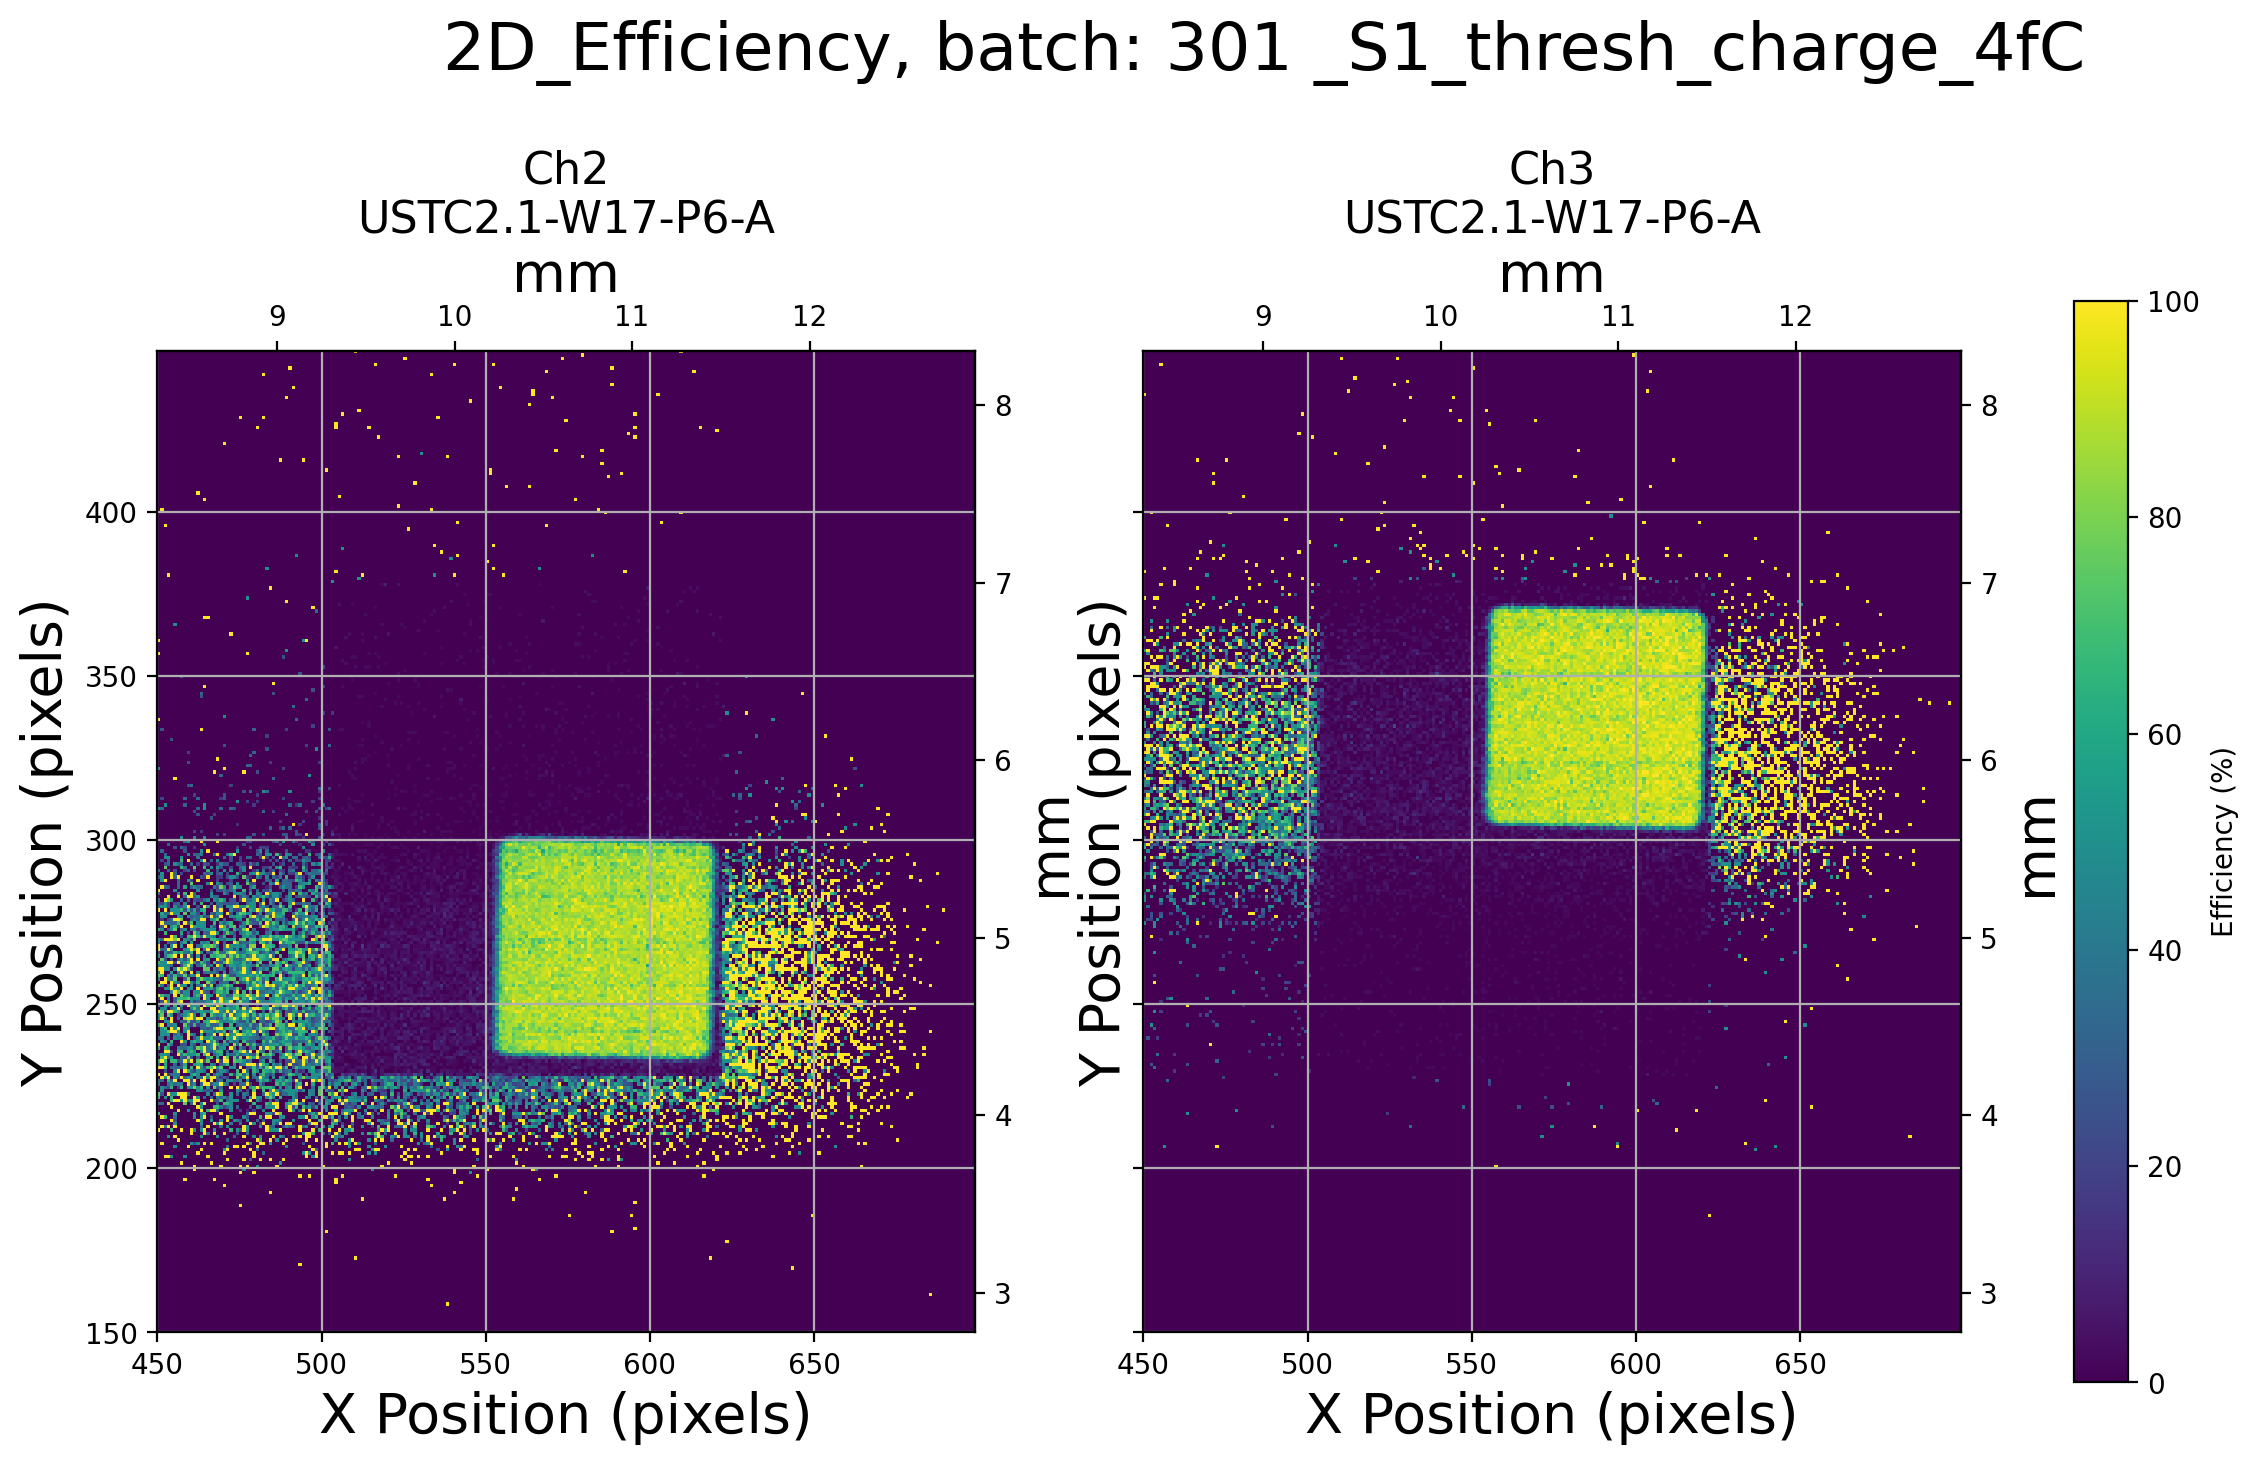

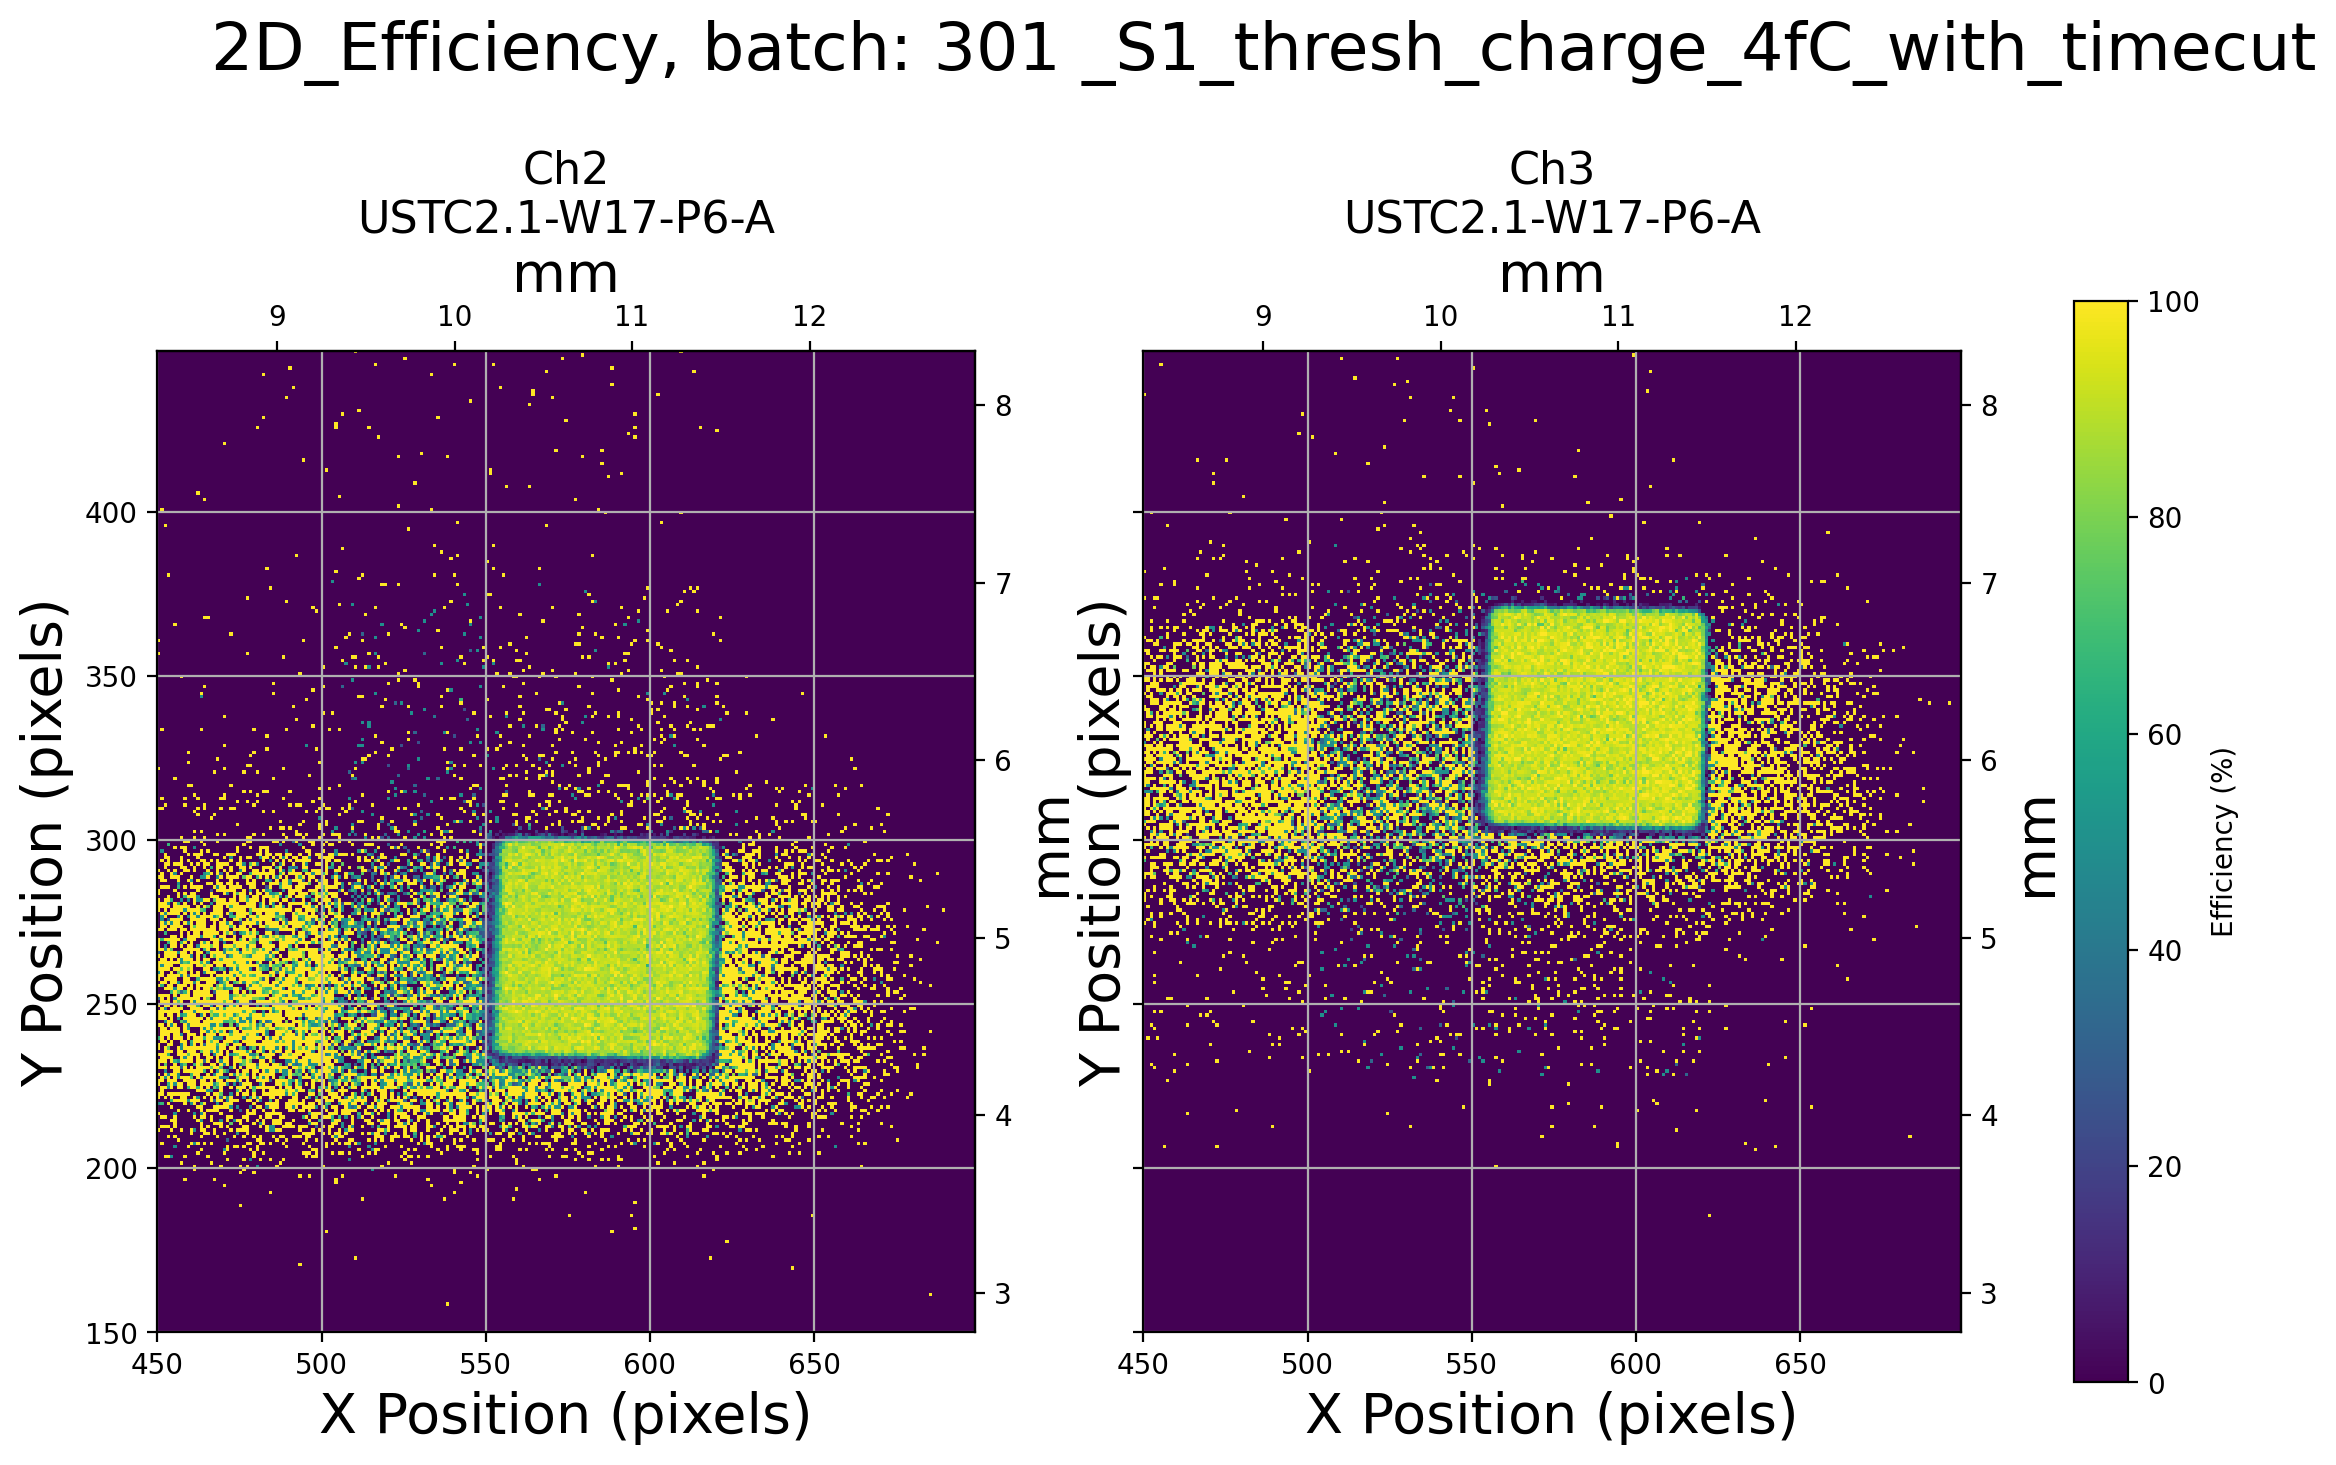

DUT_1
DUT_2


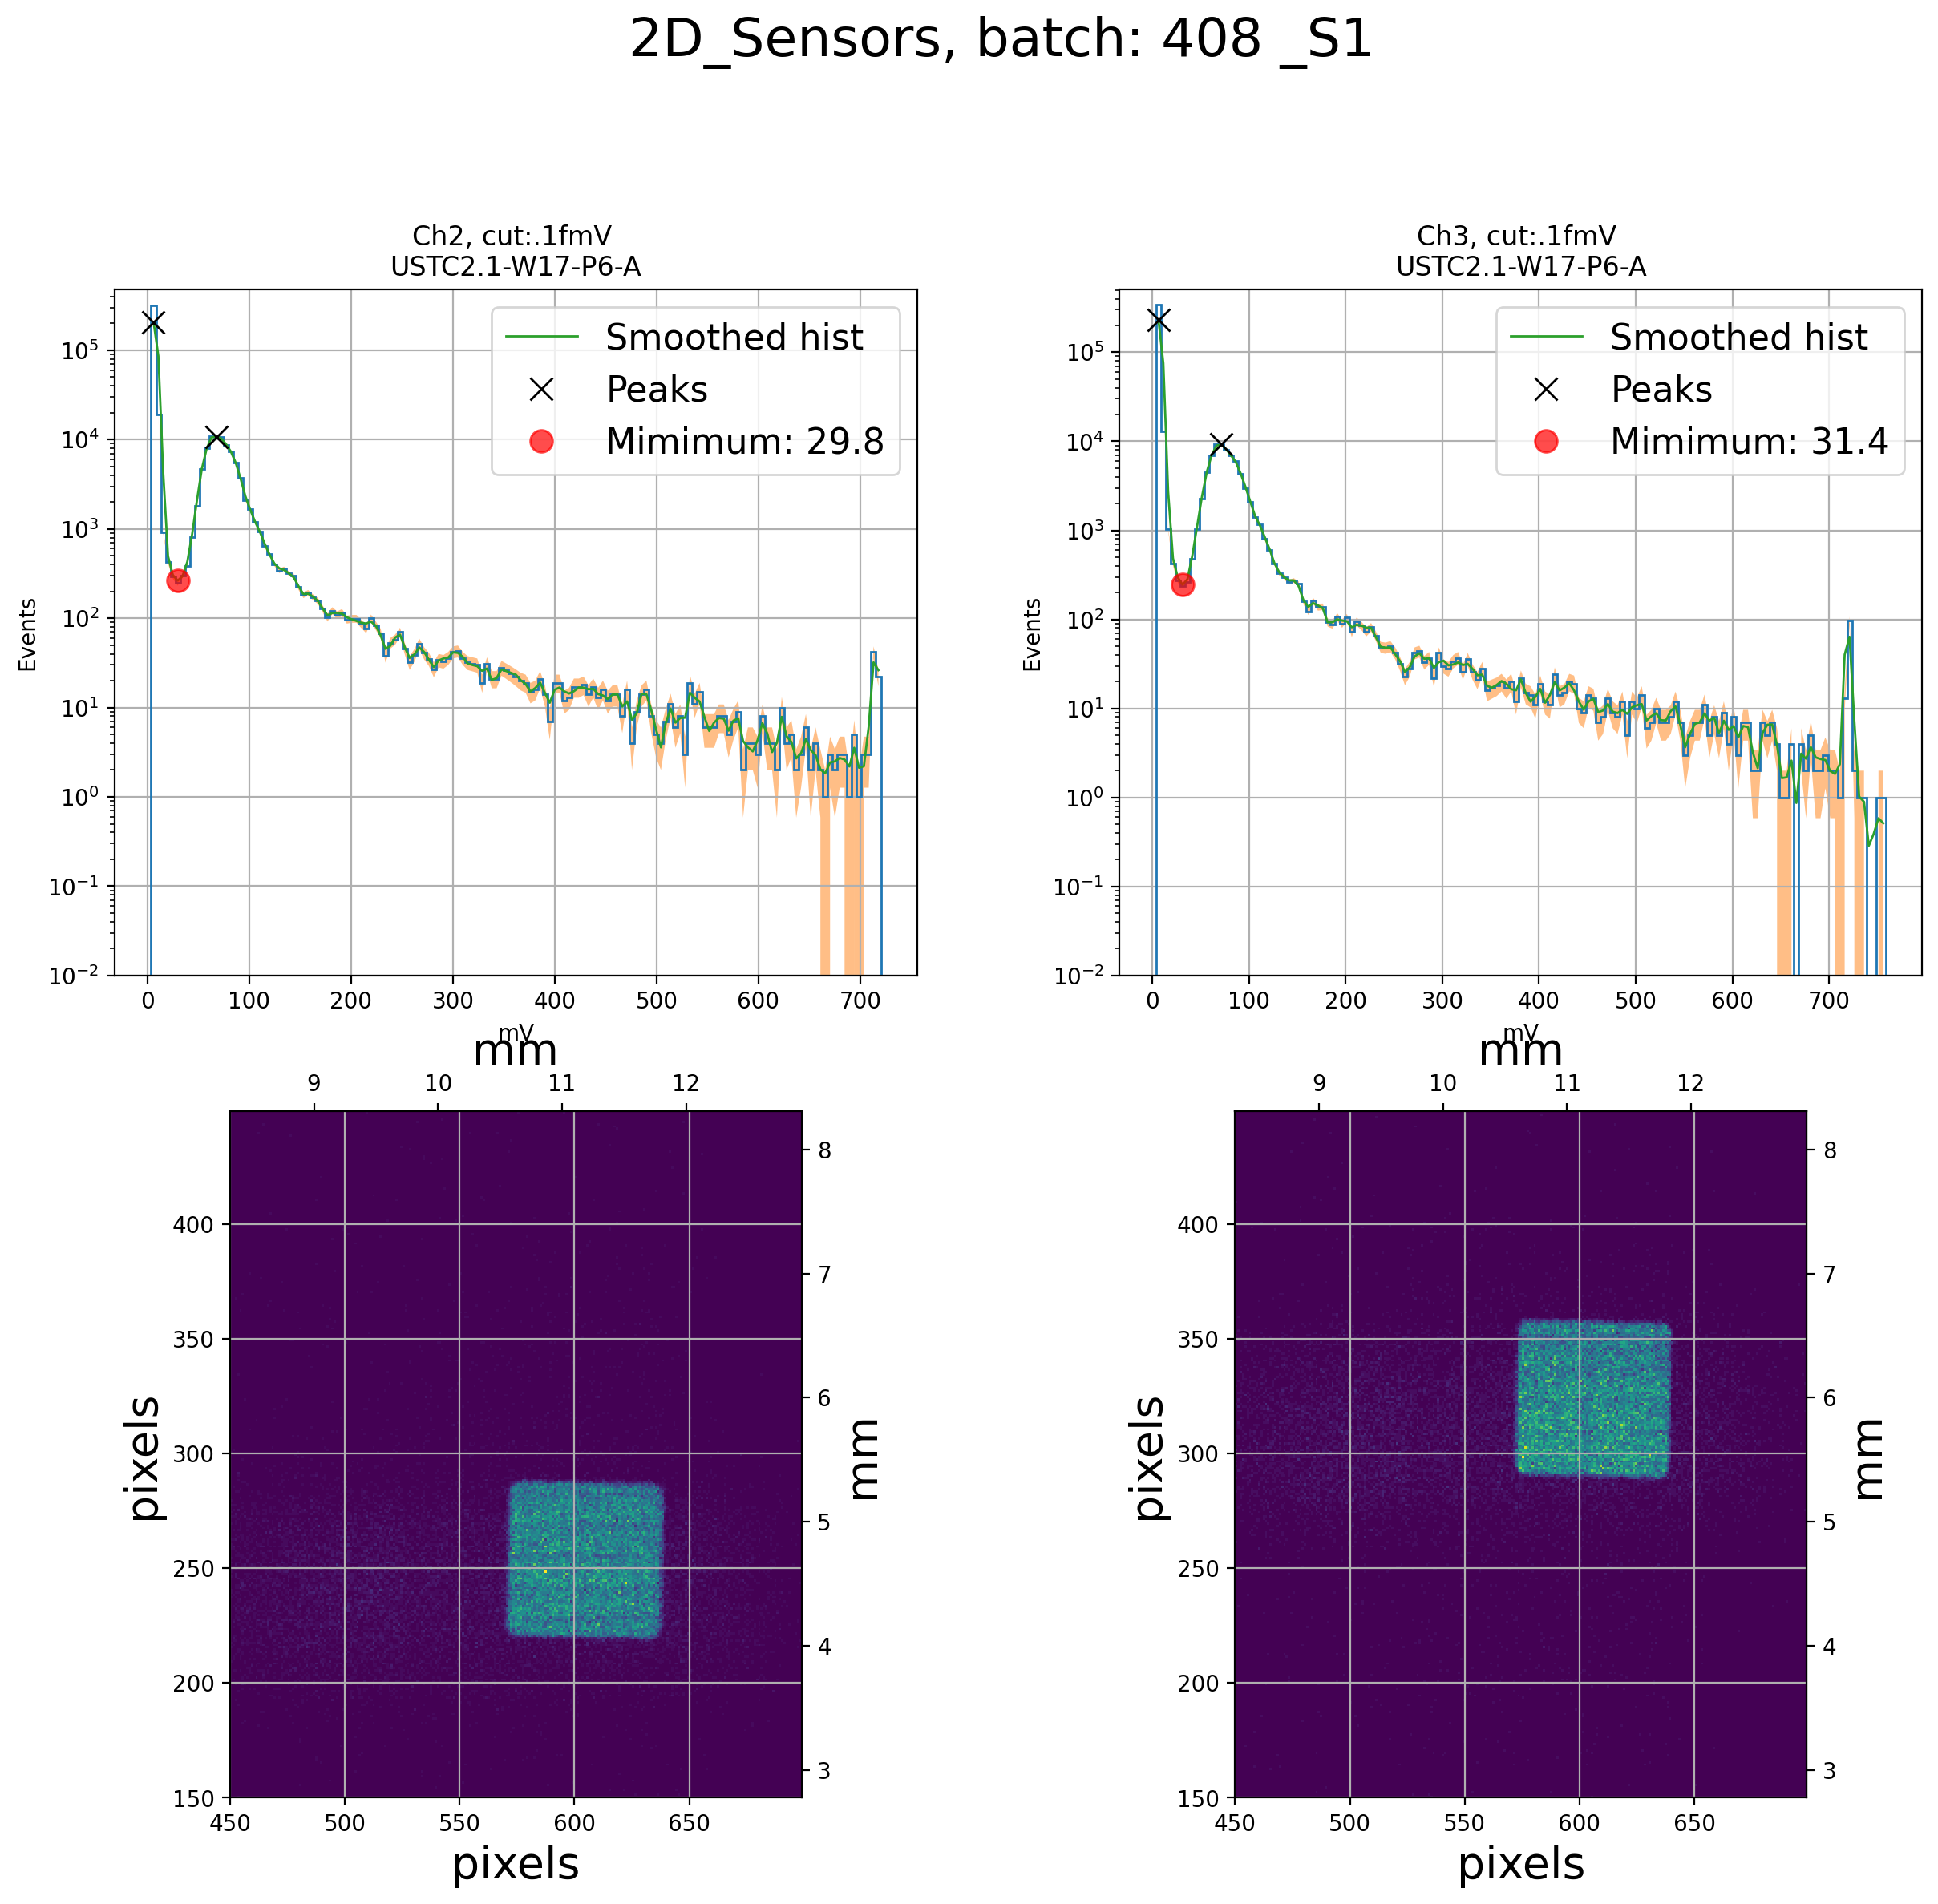

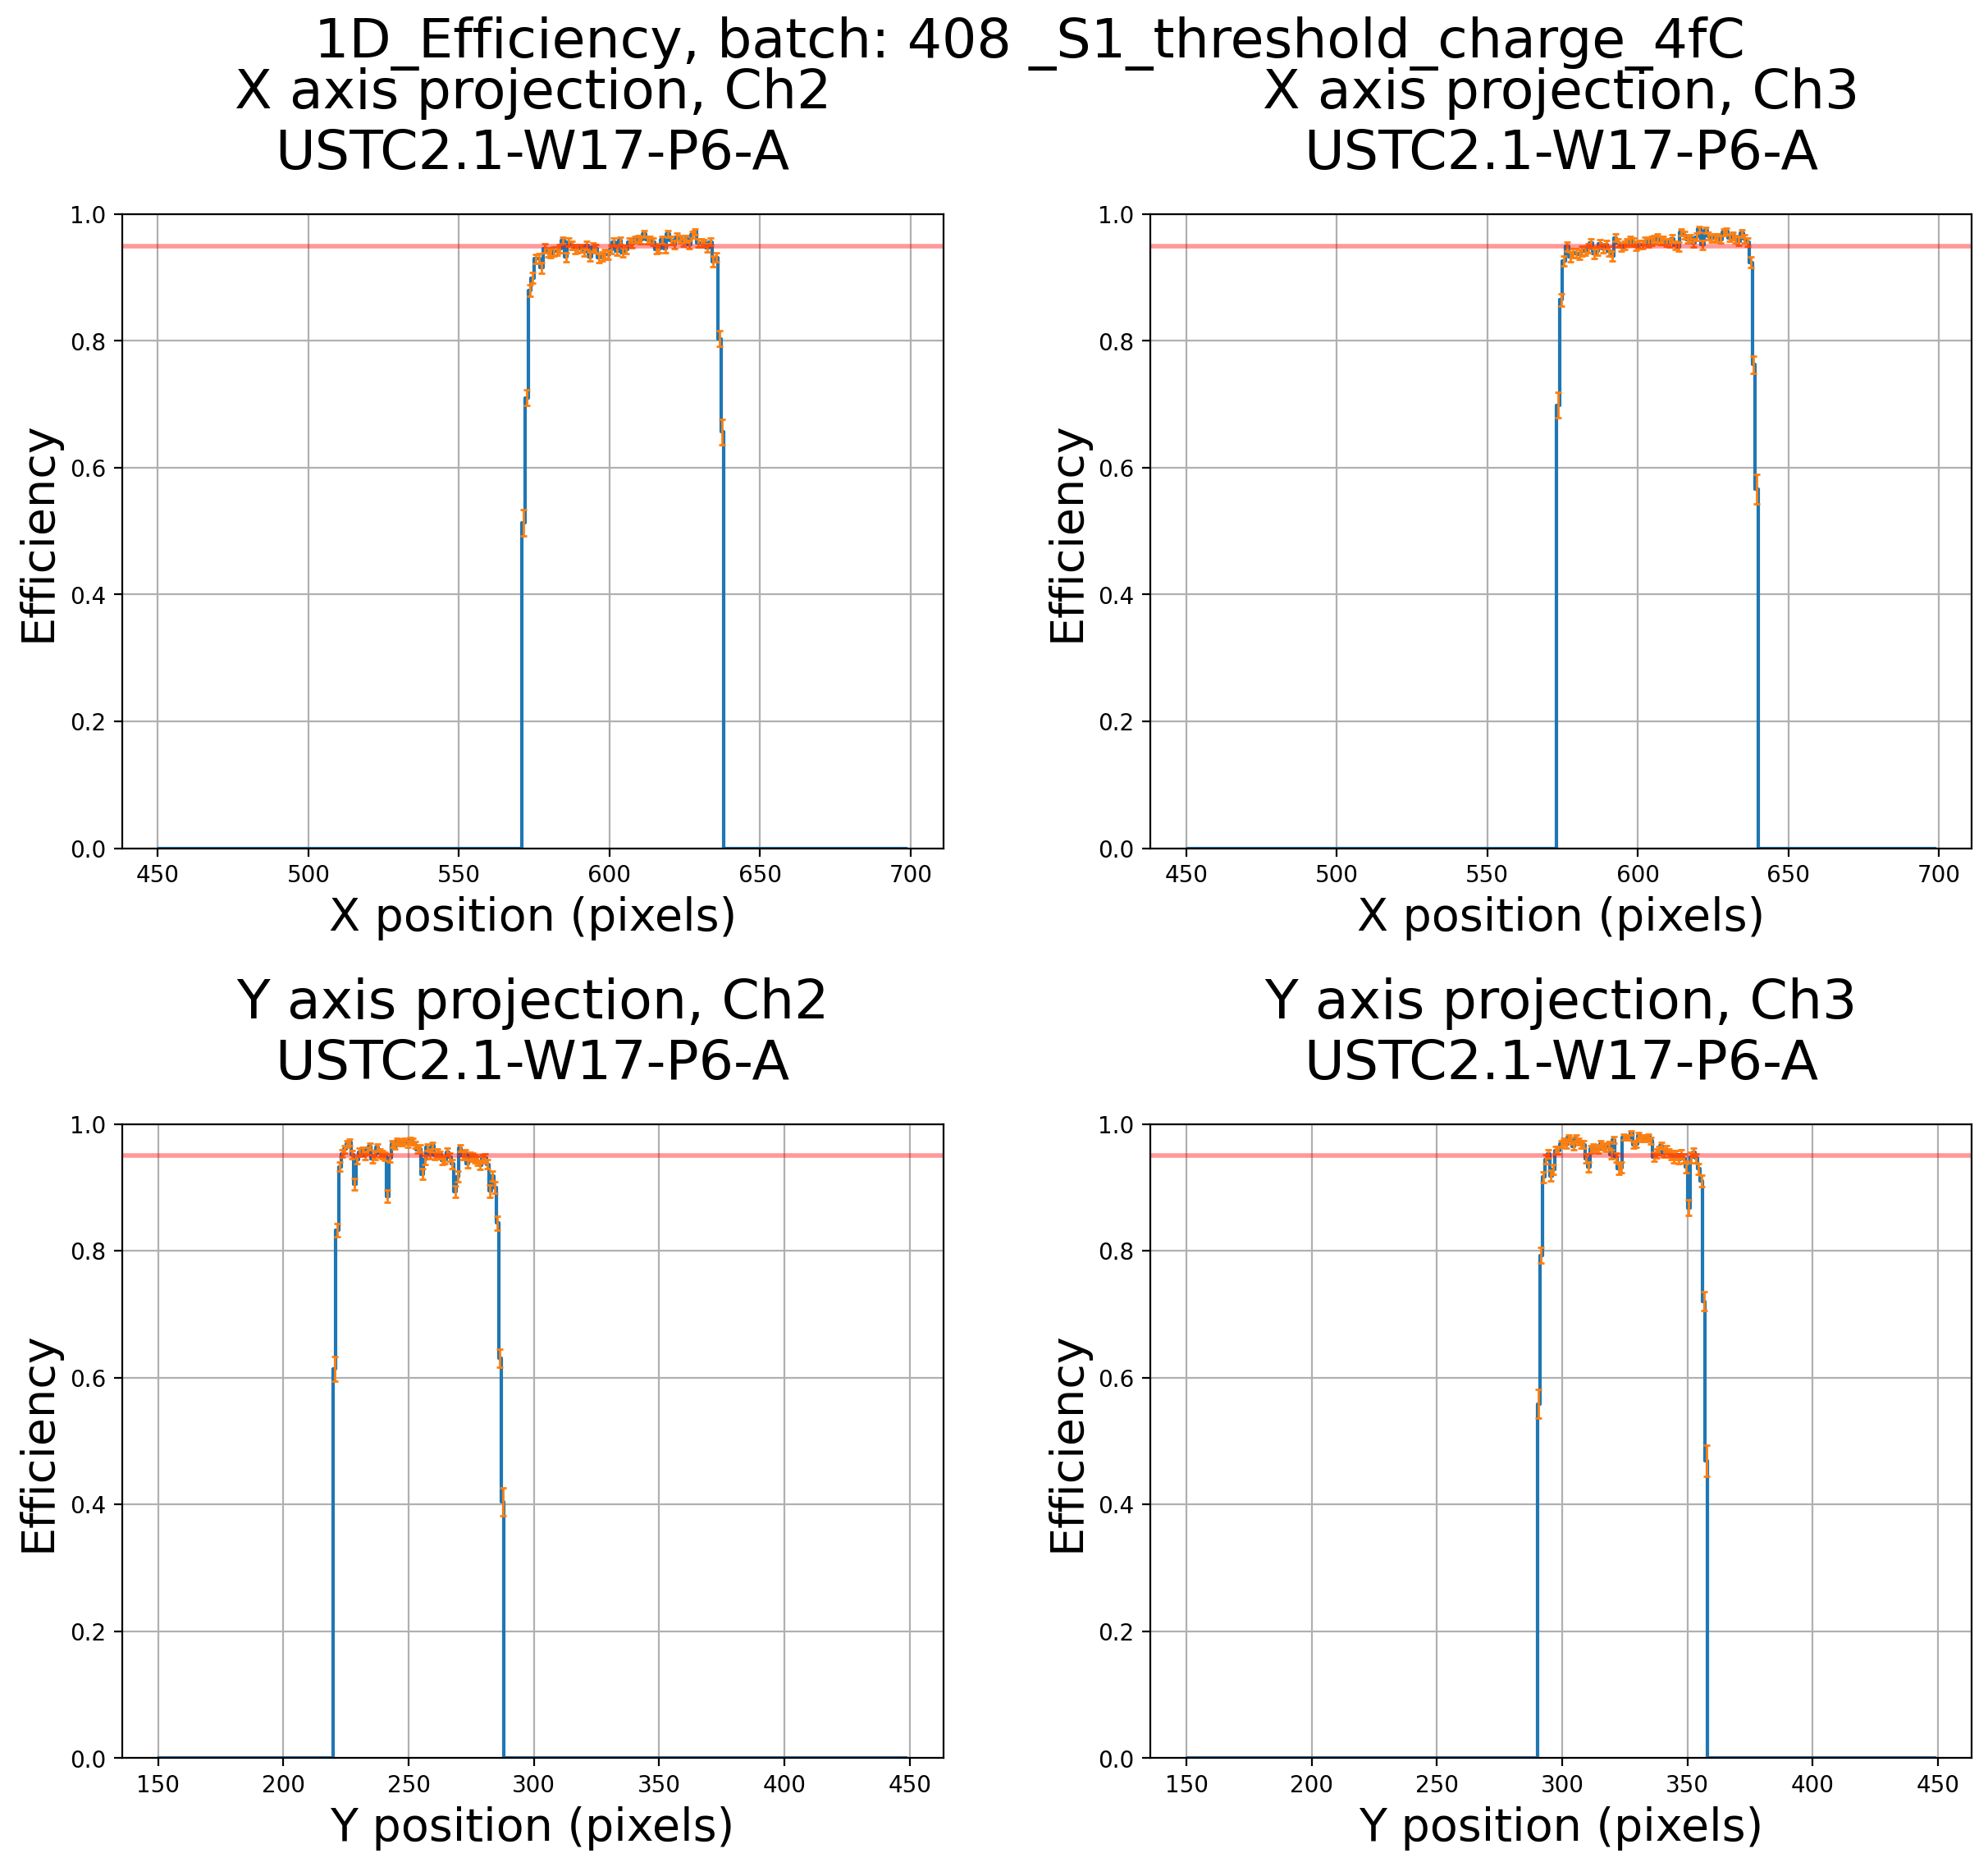

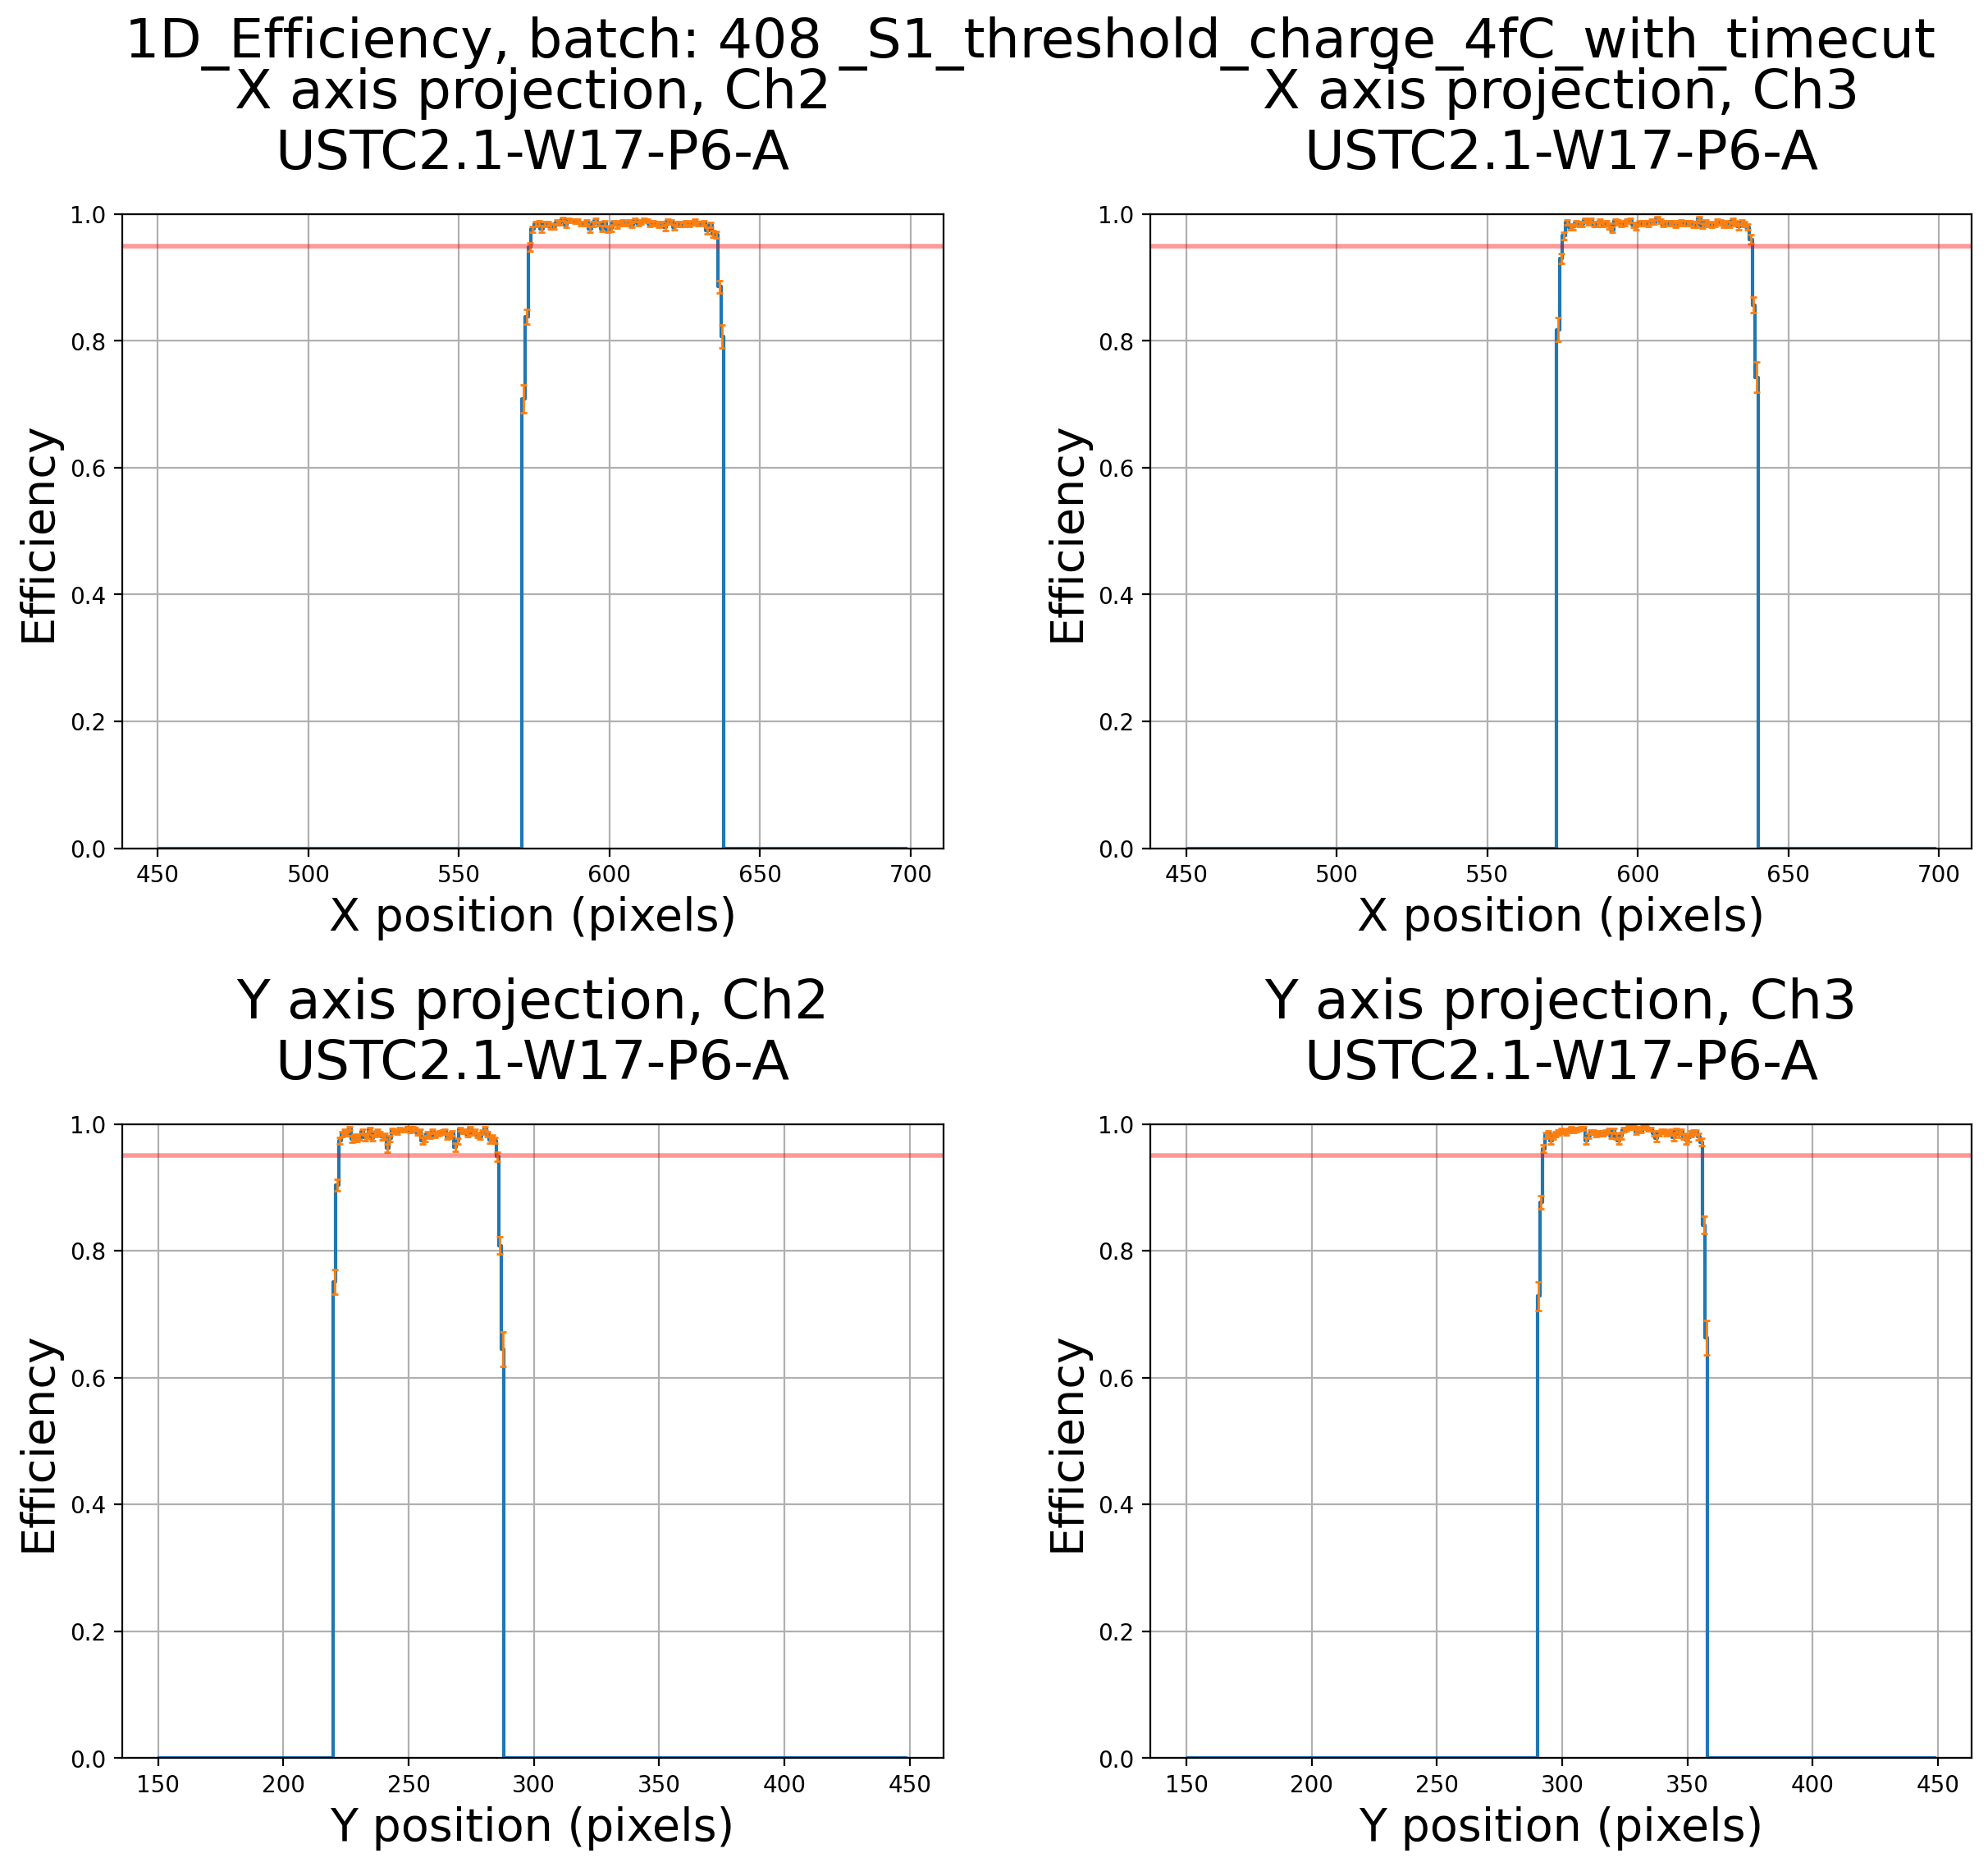

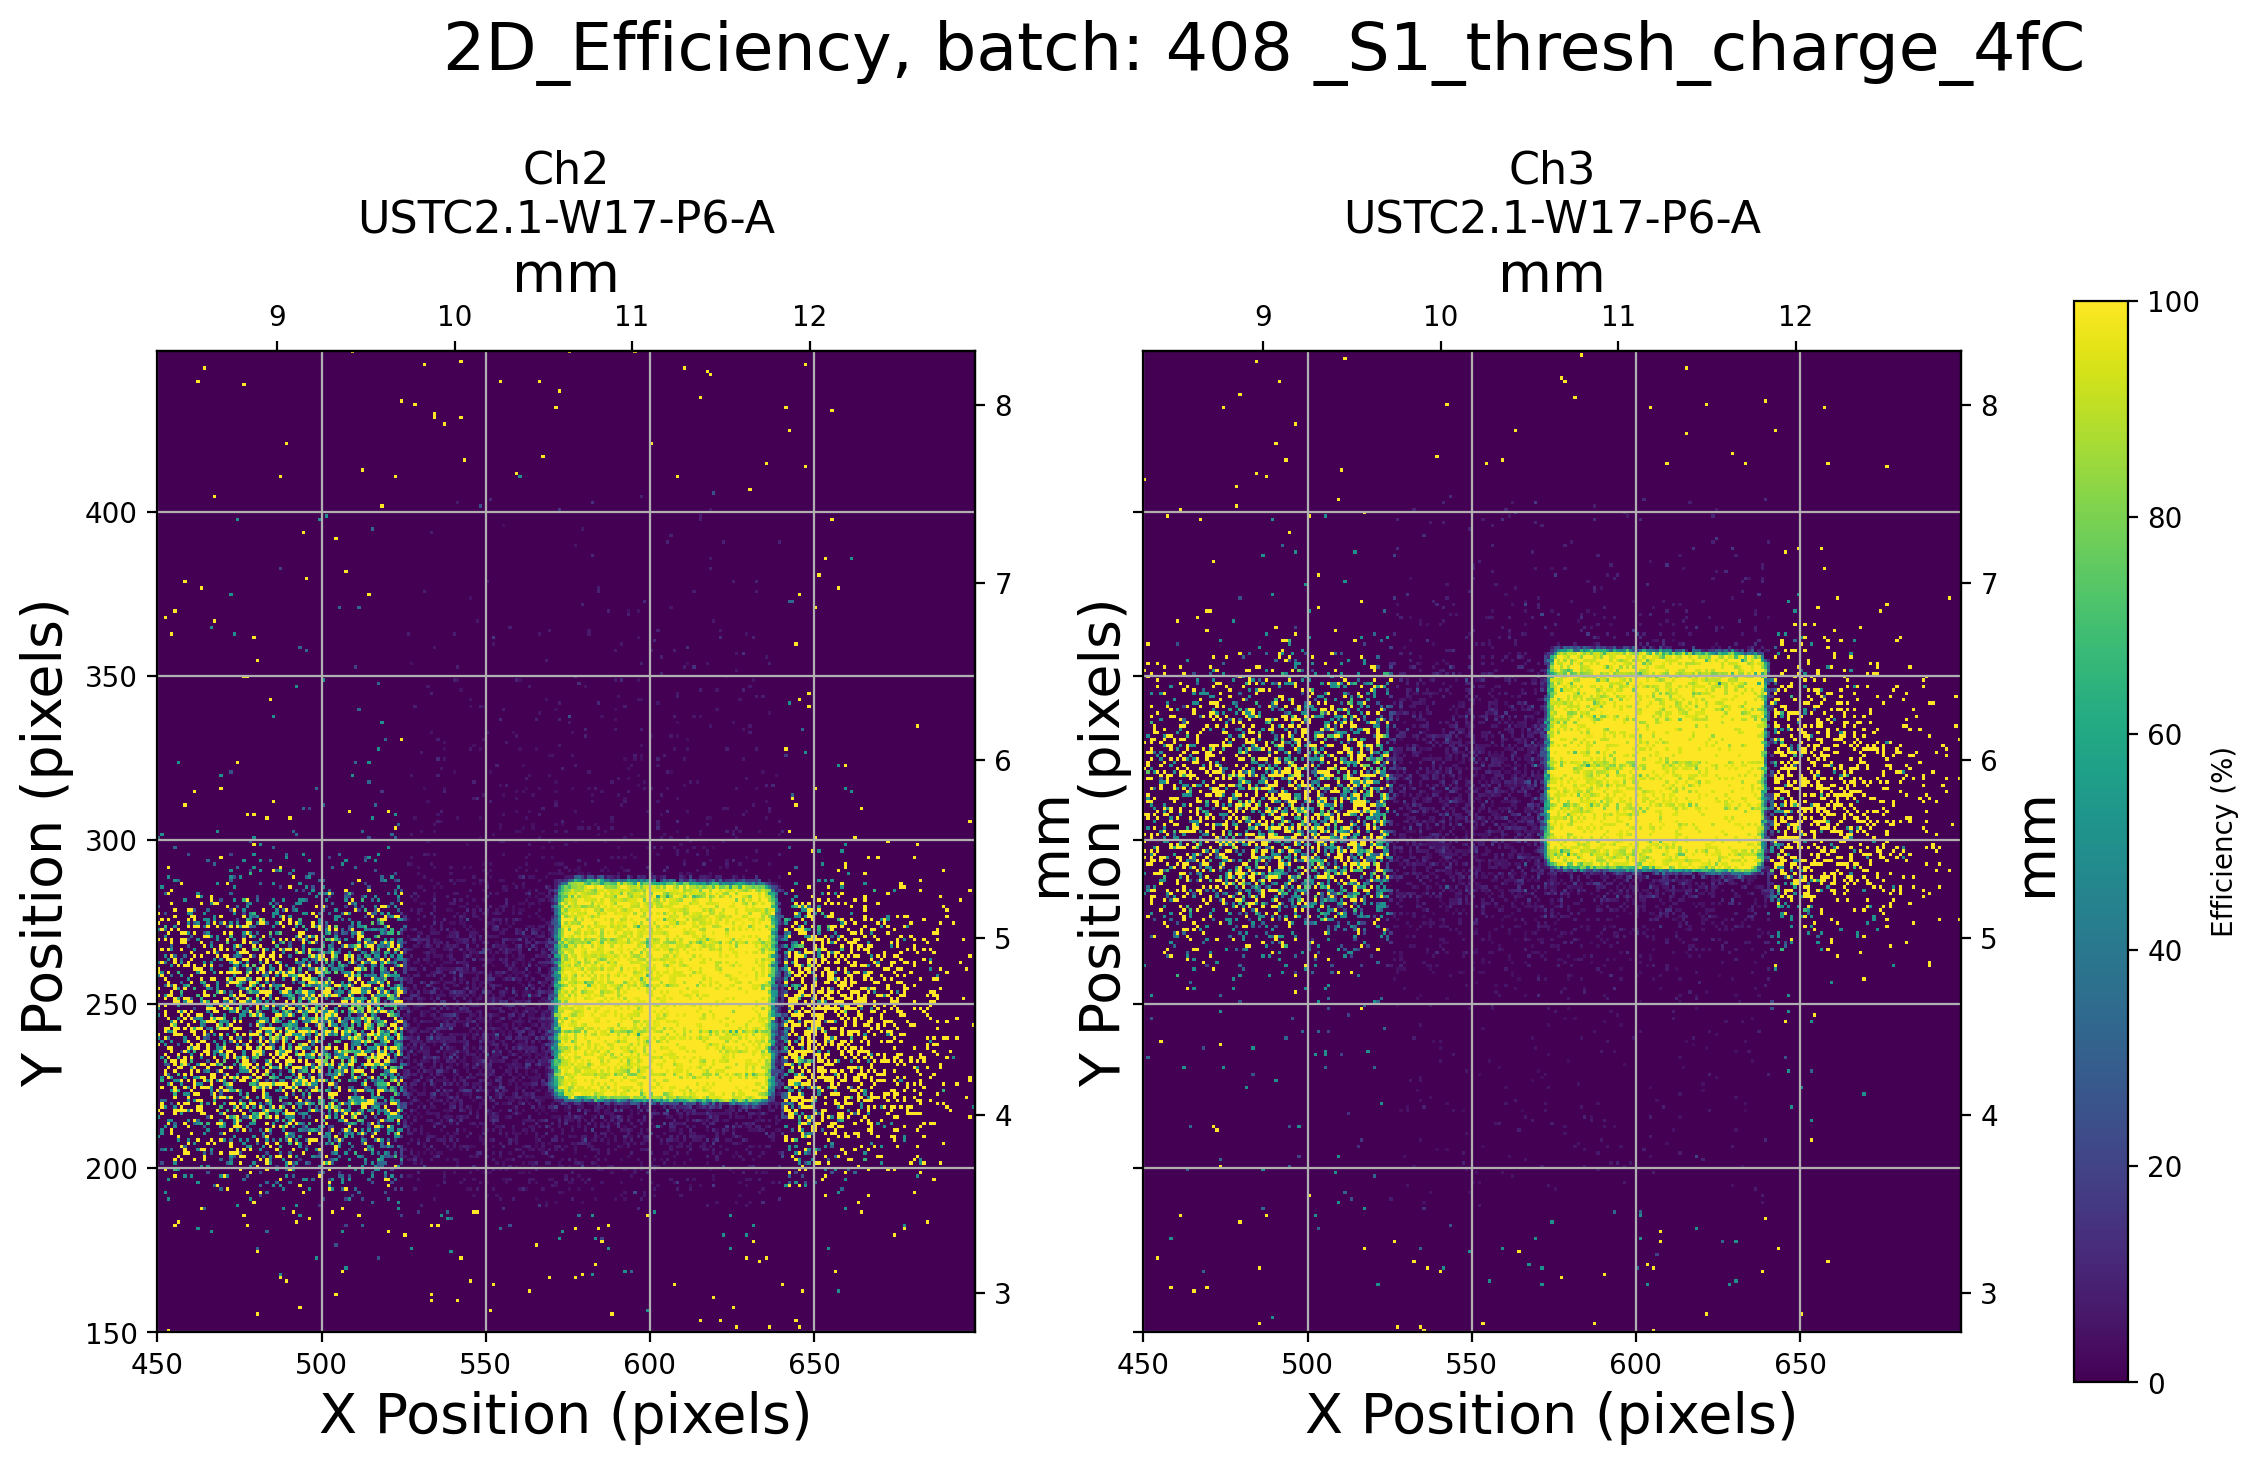

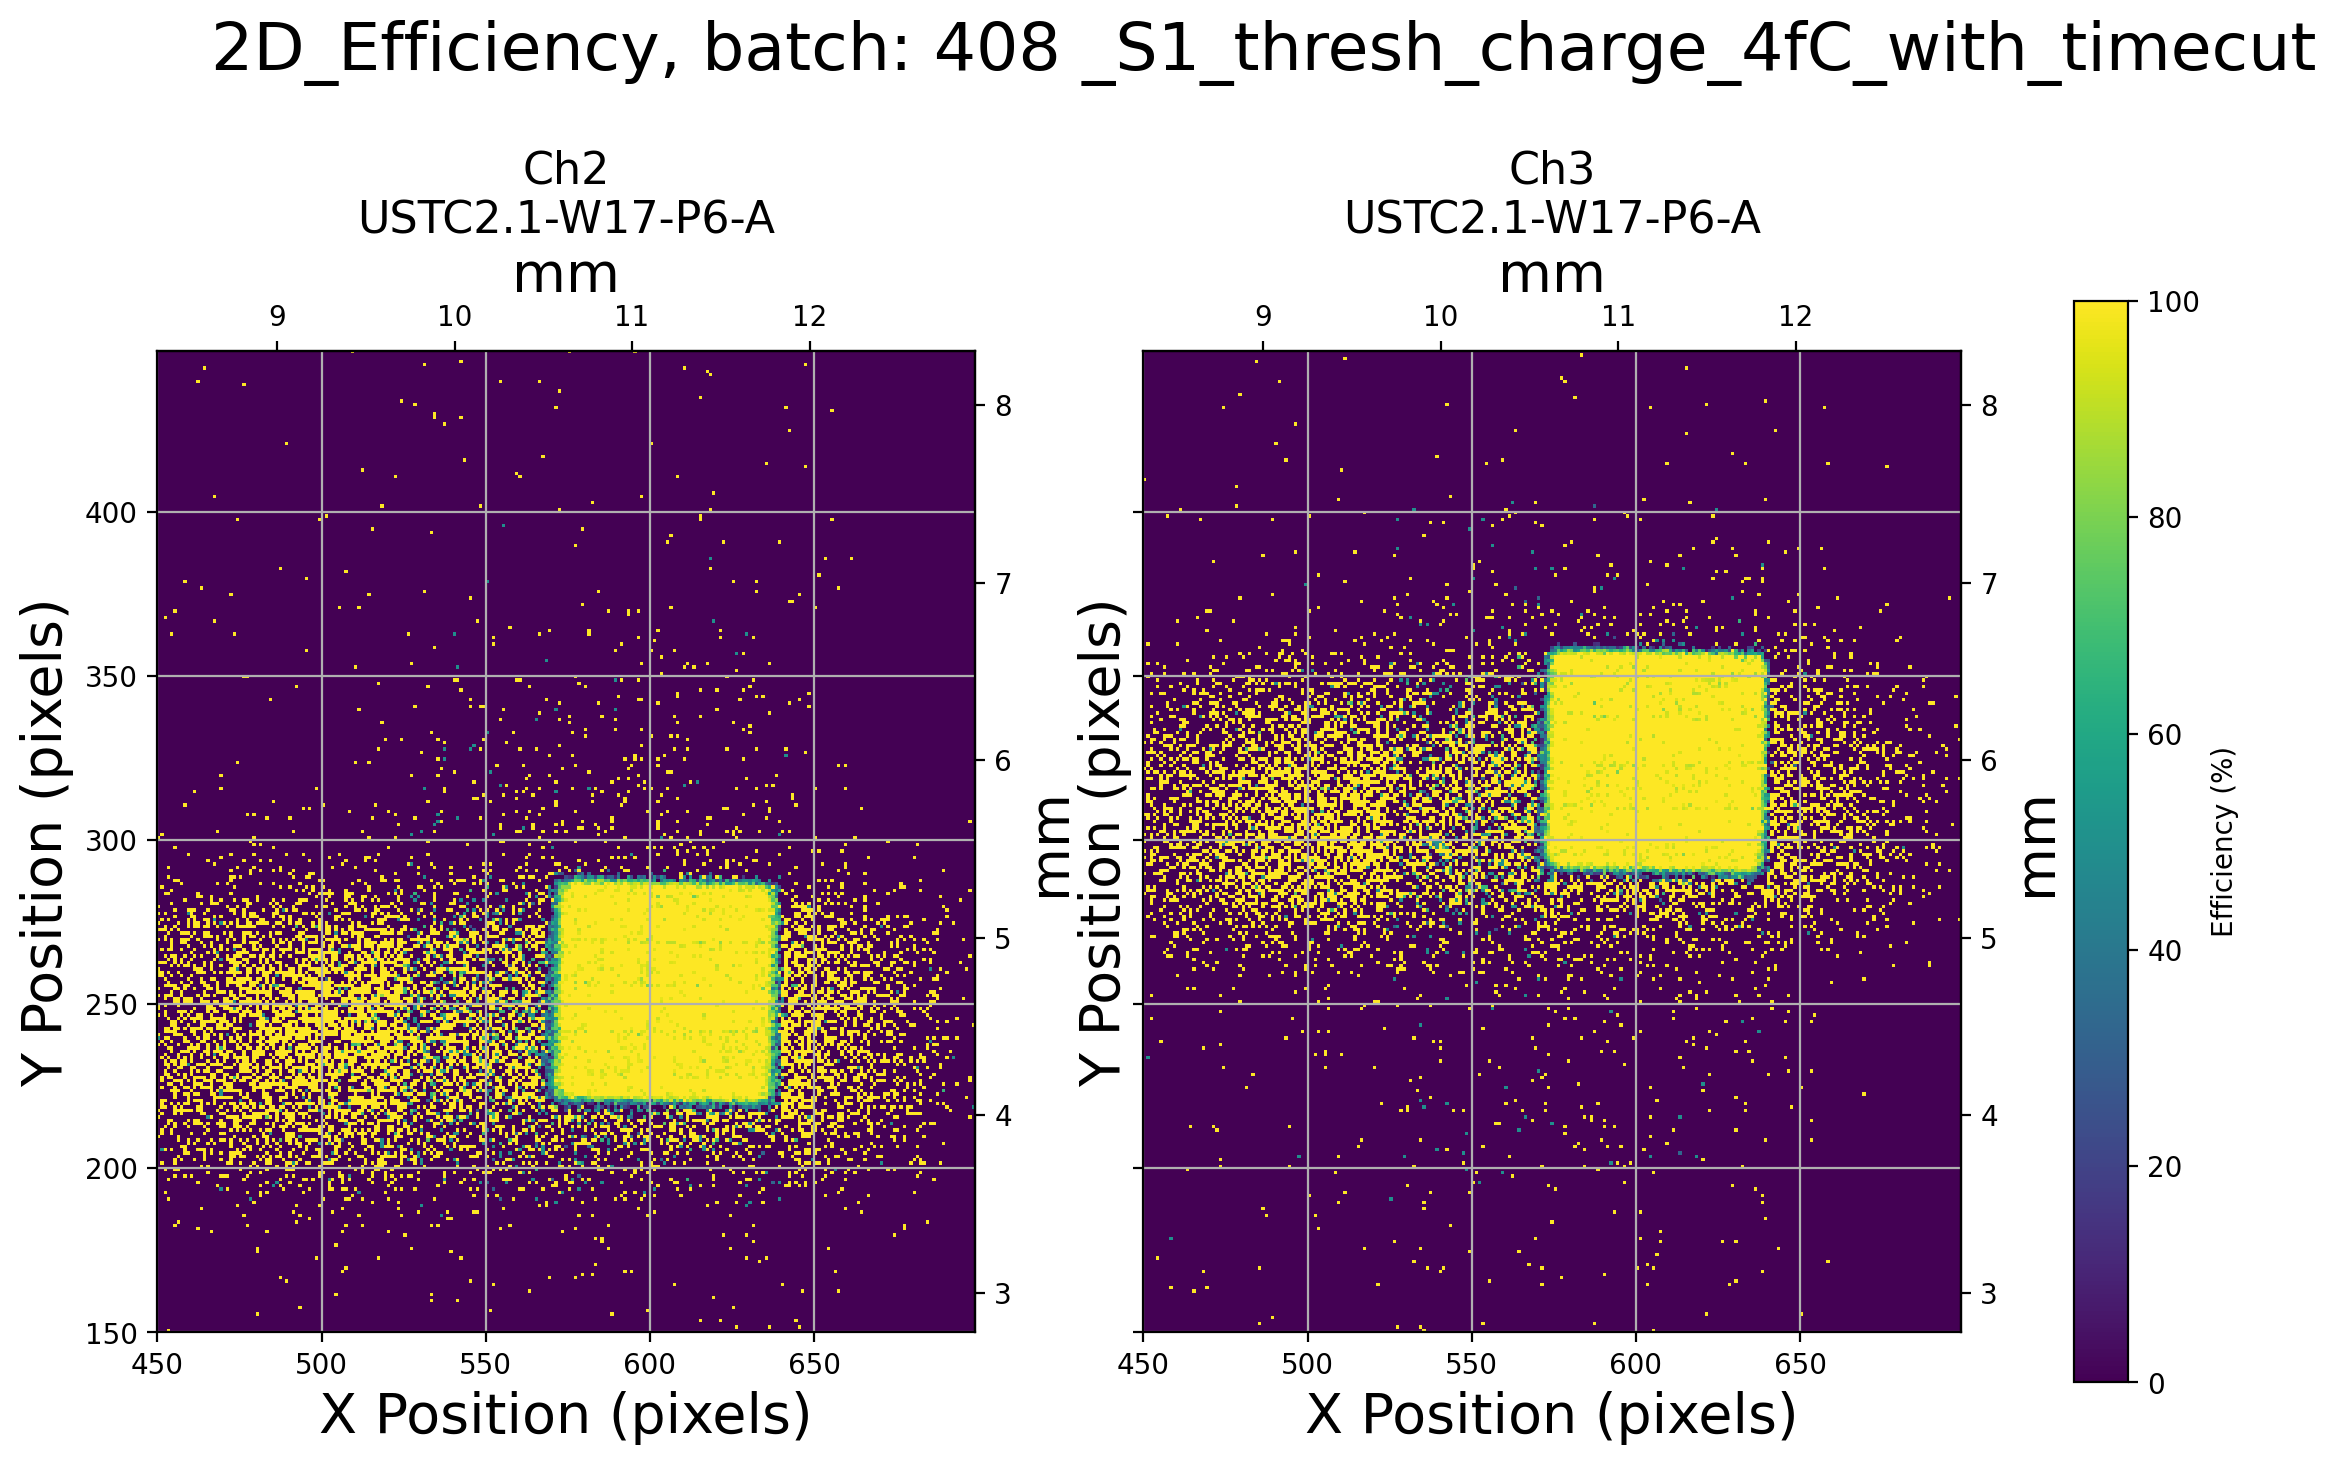

DUT_1
DUT_2


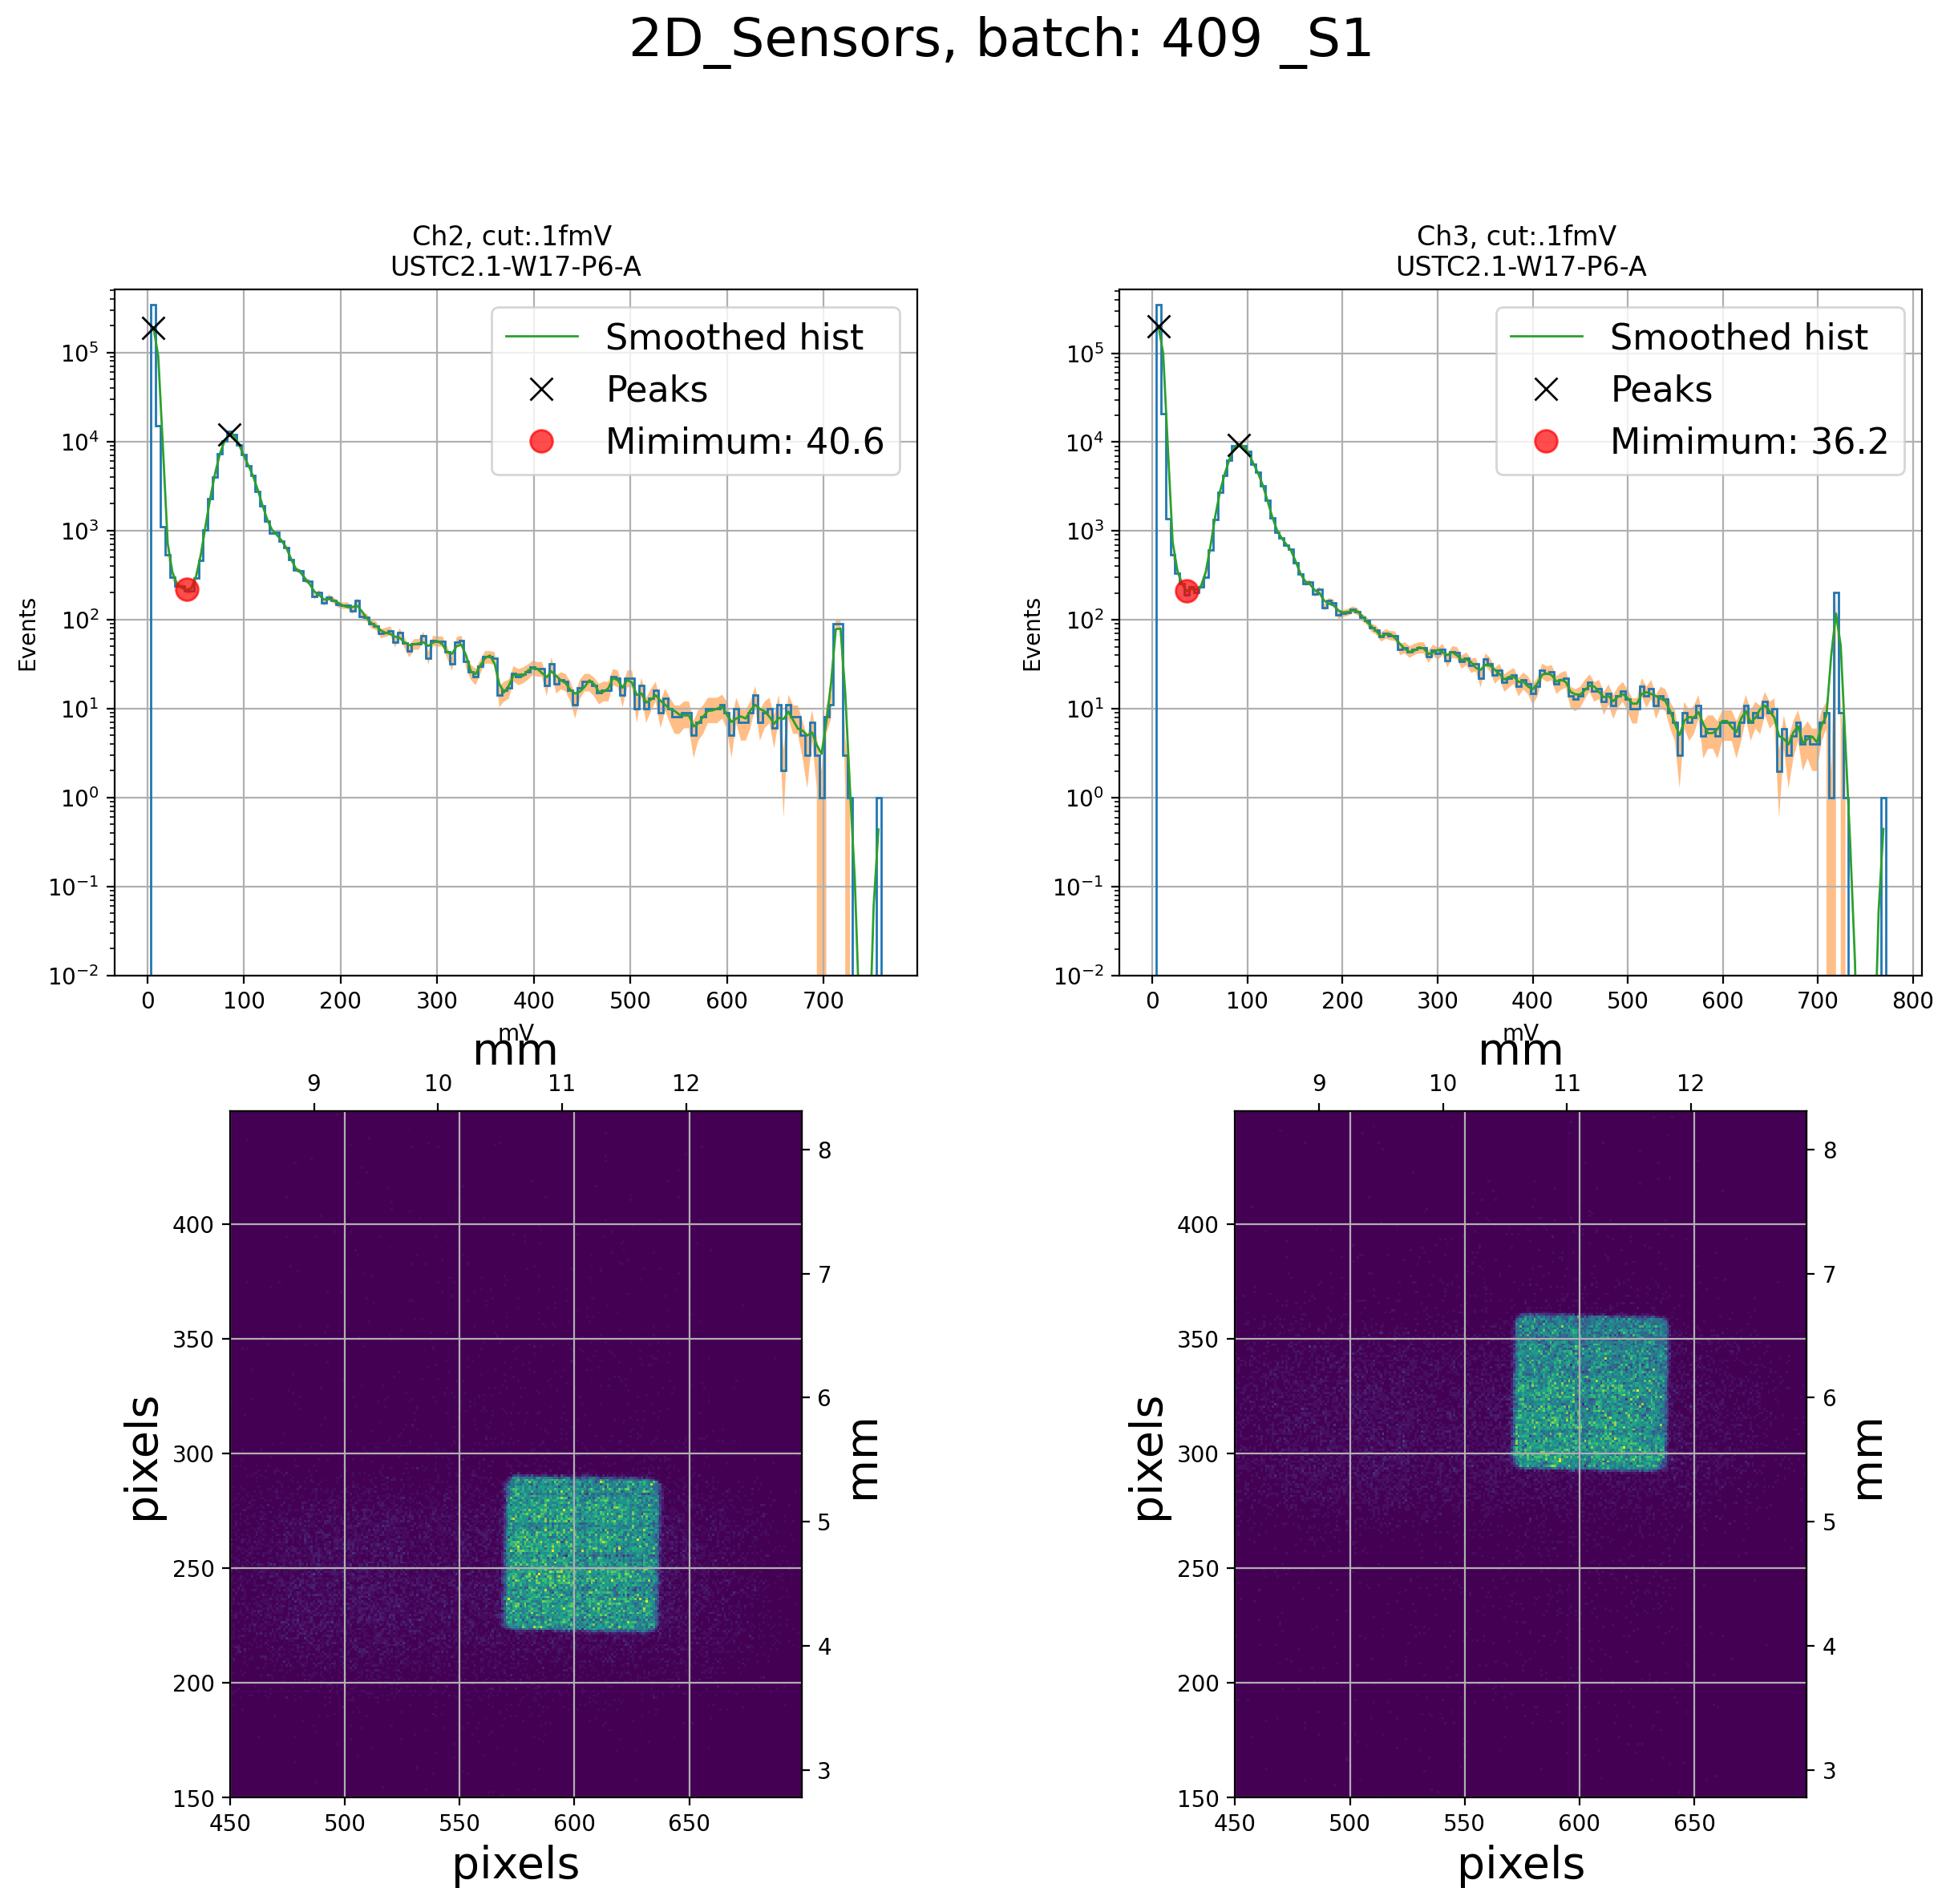

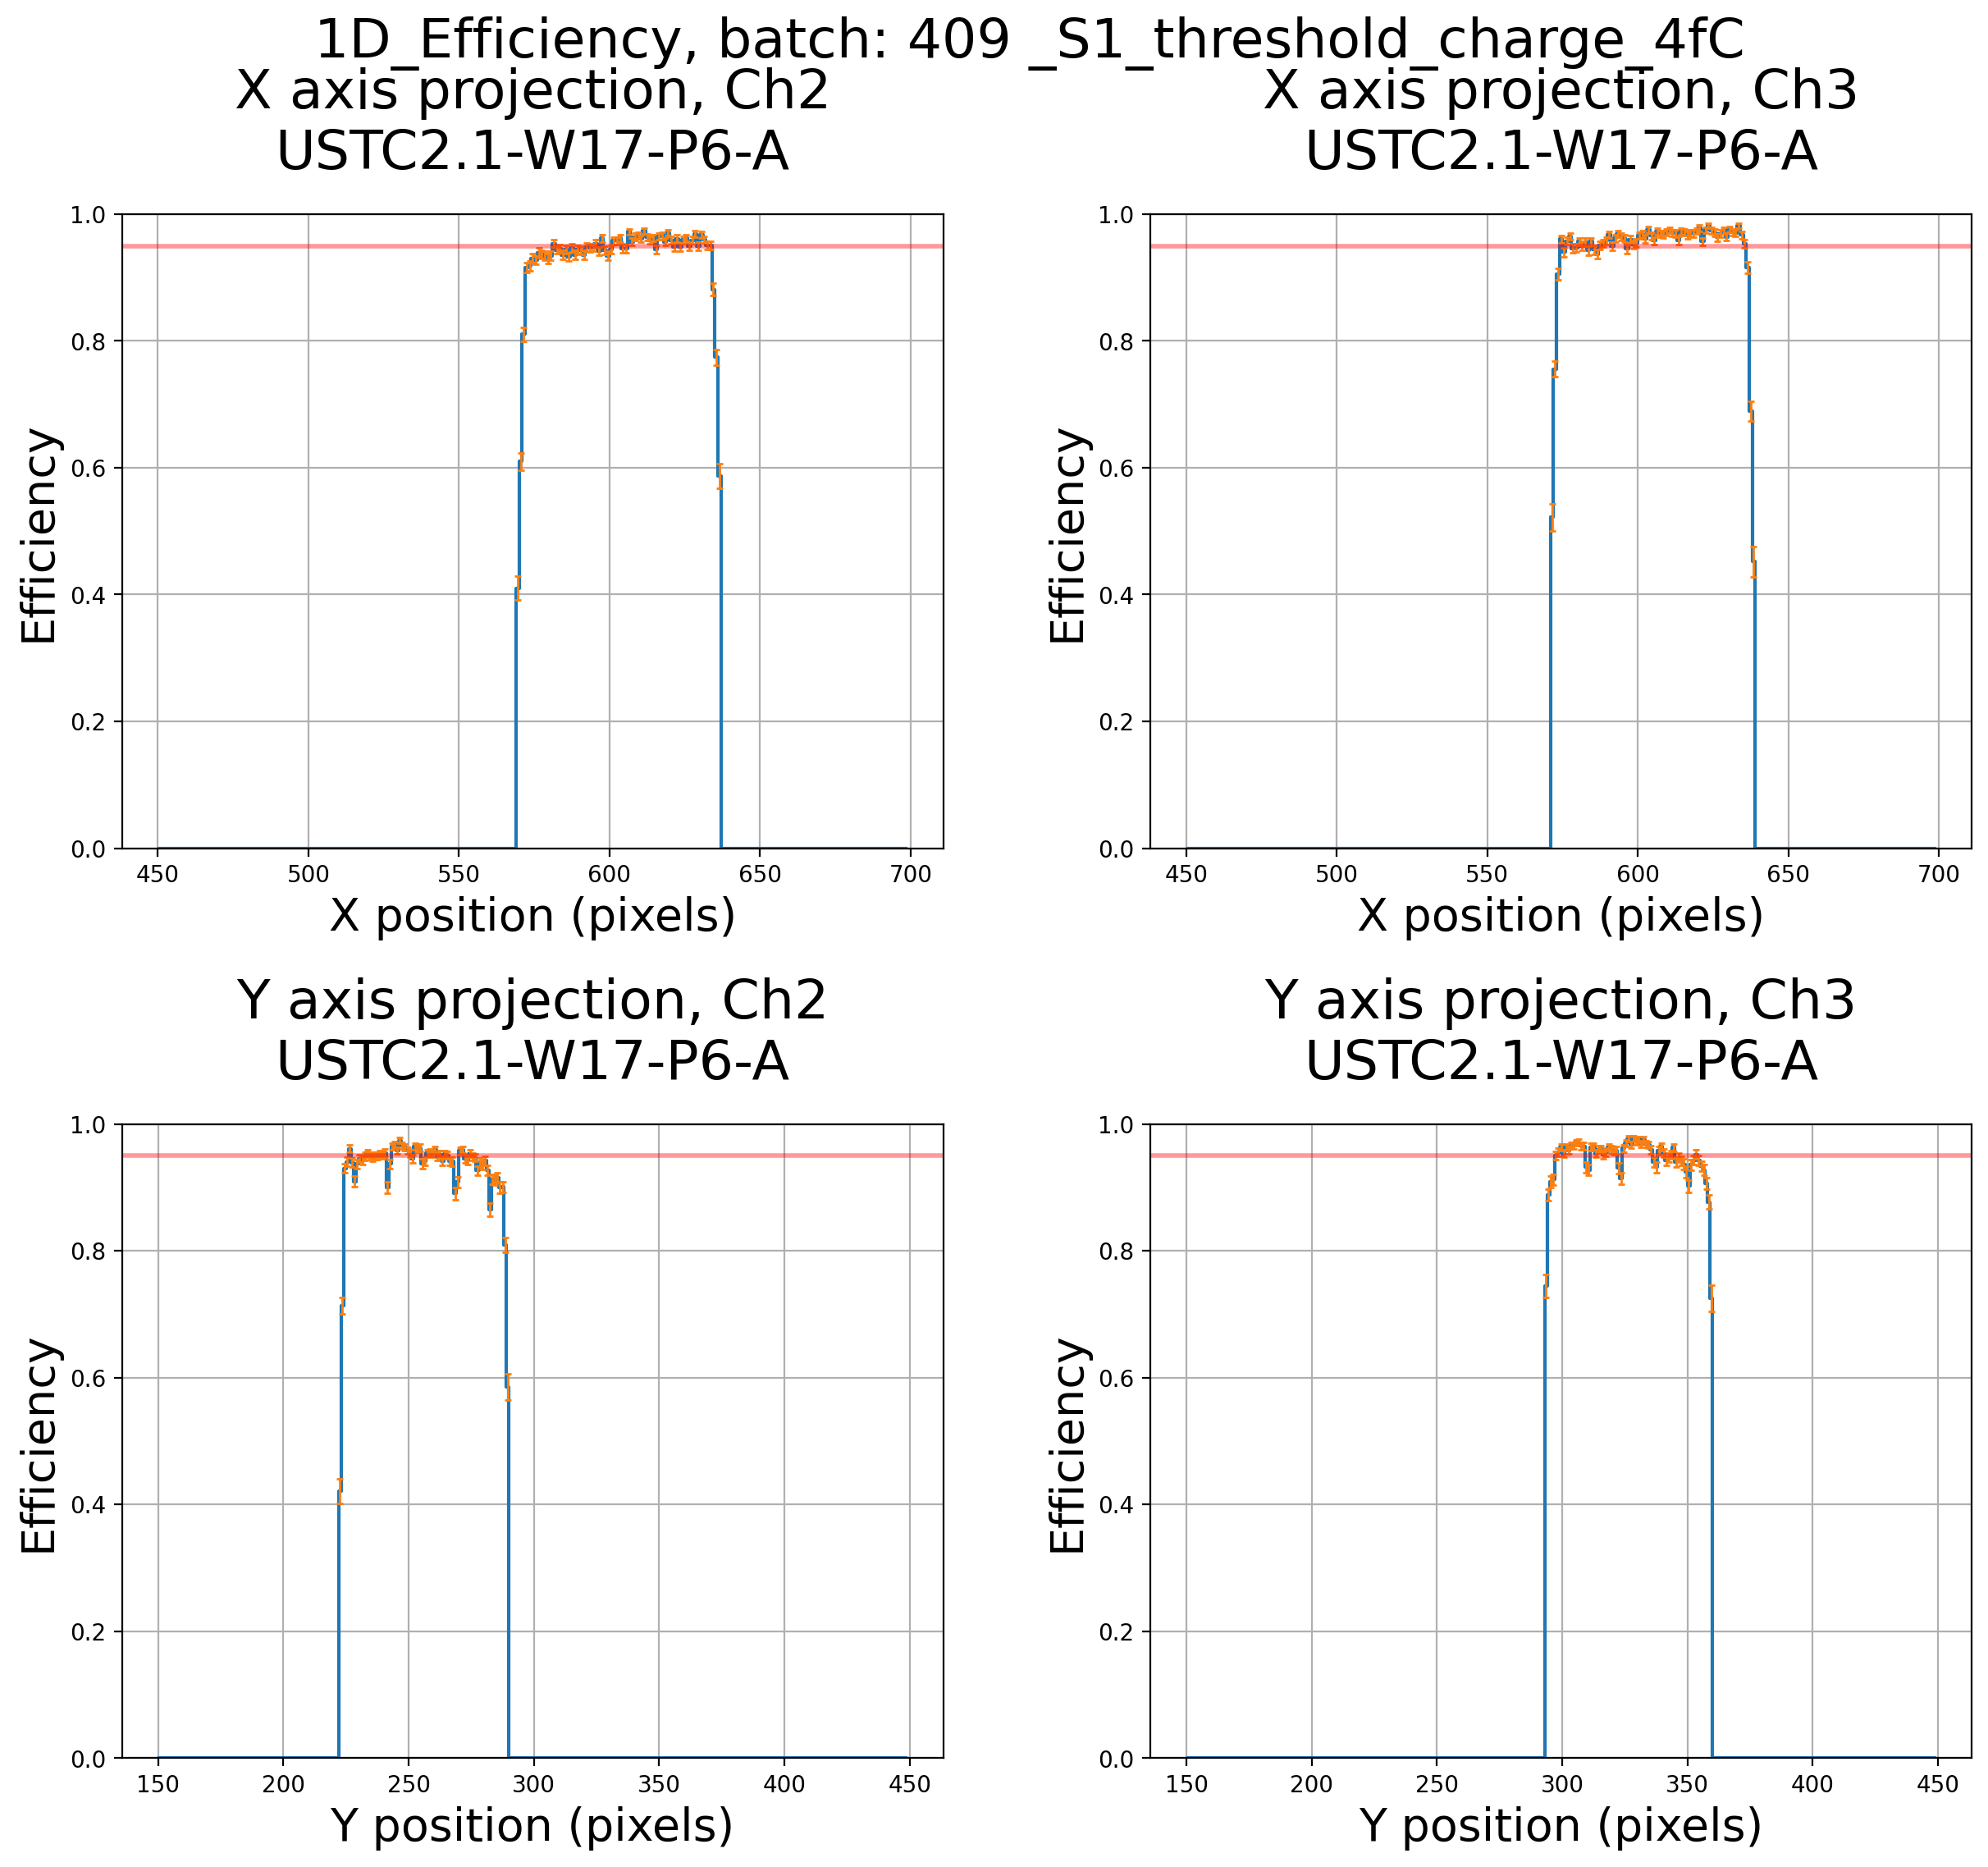

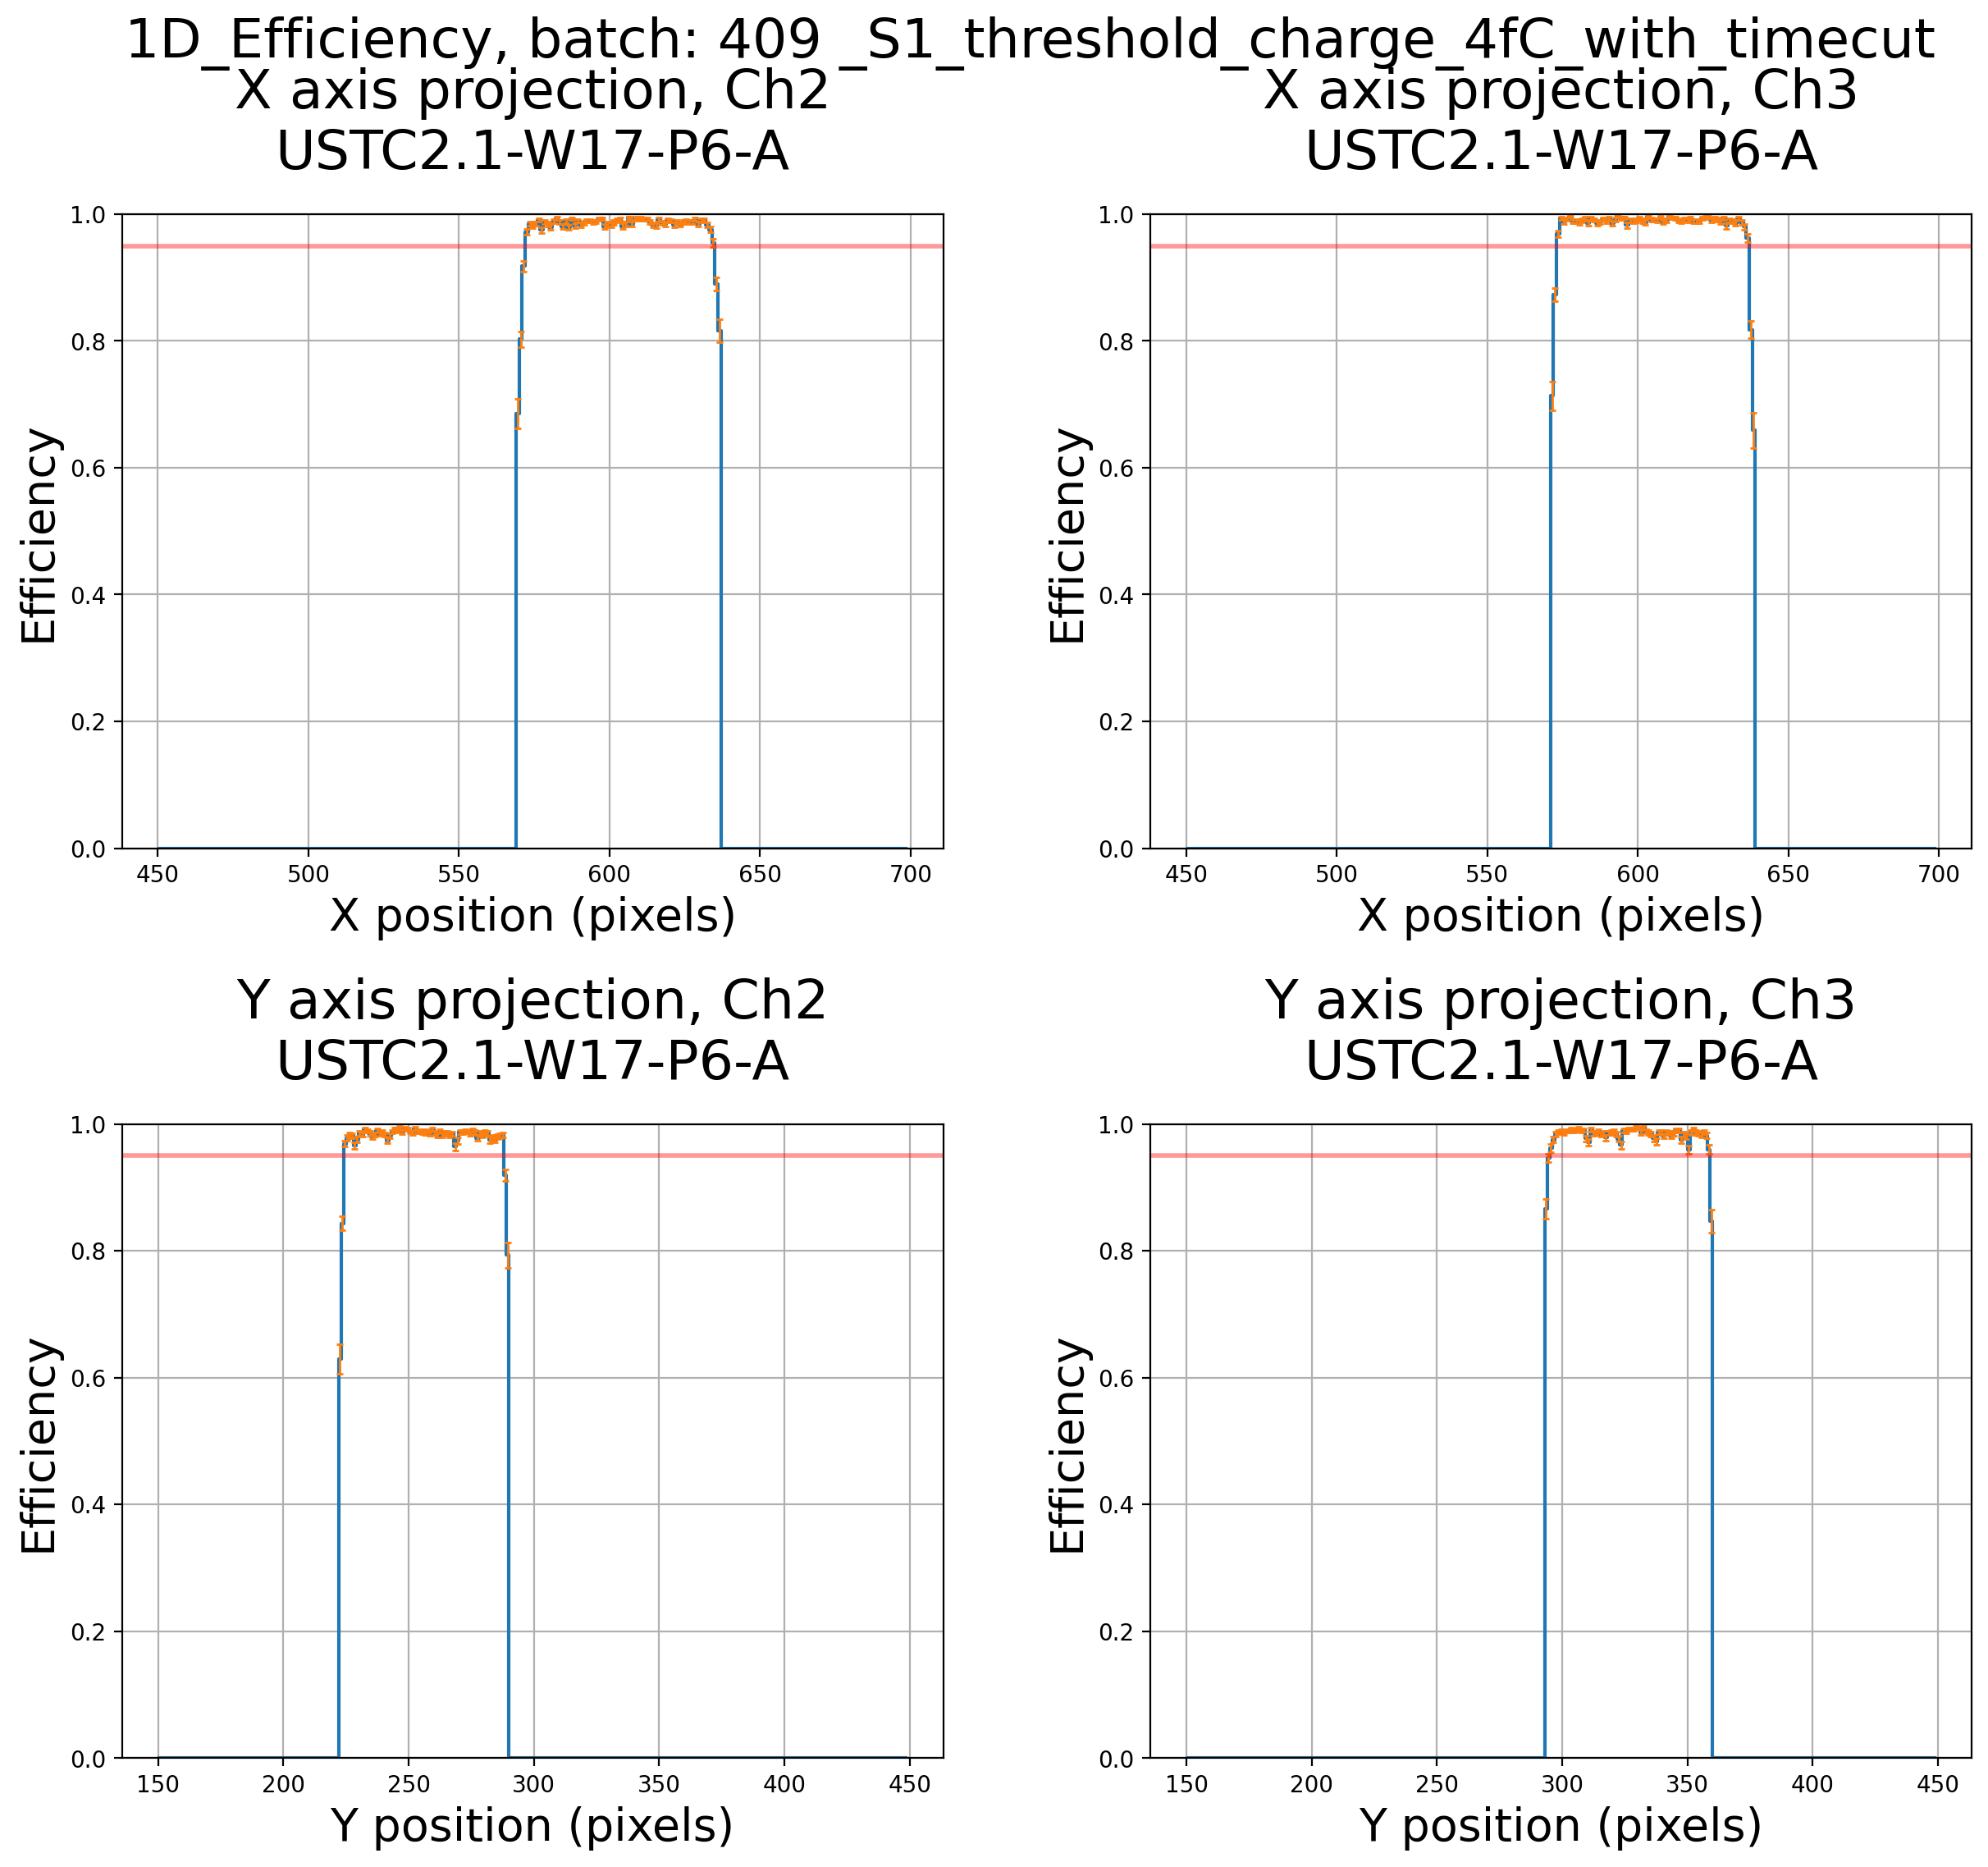

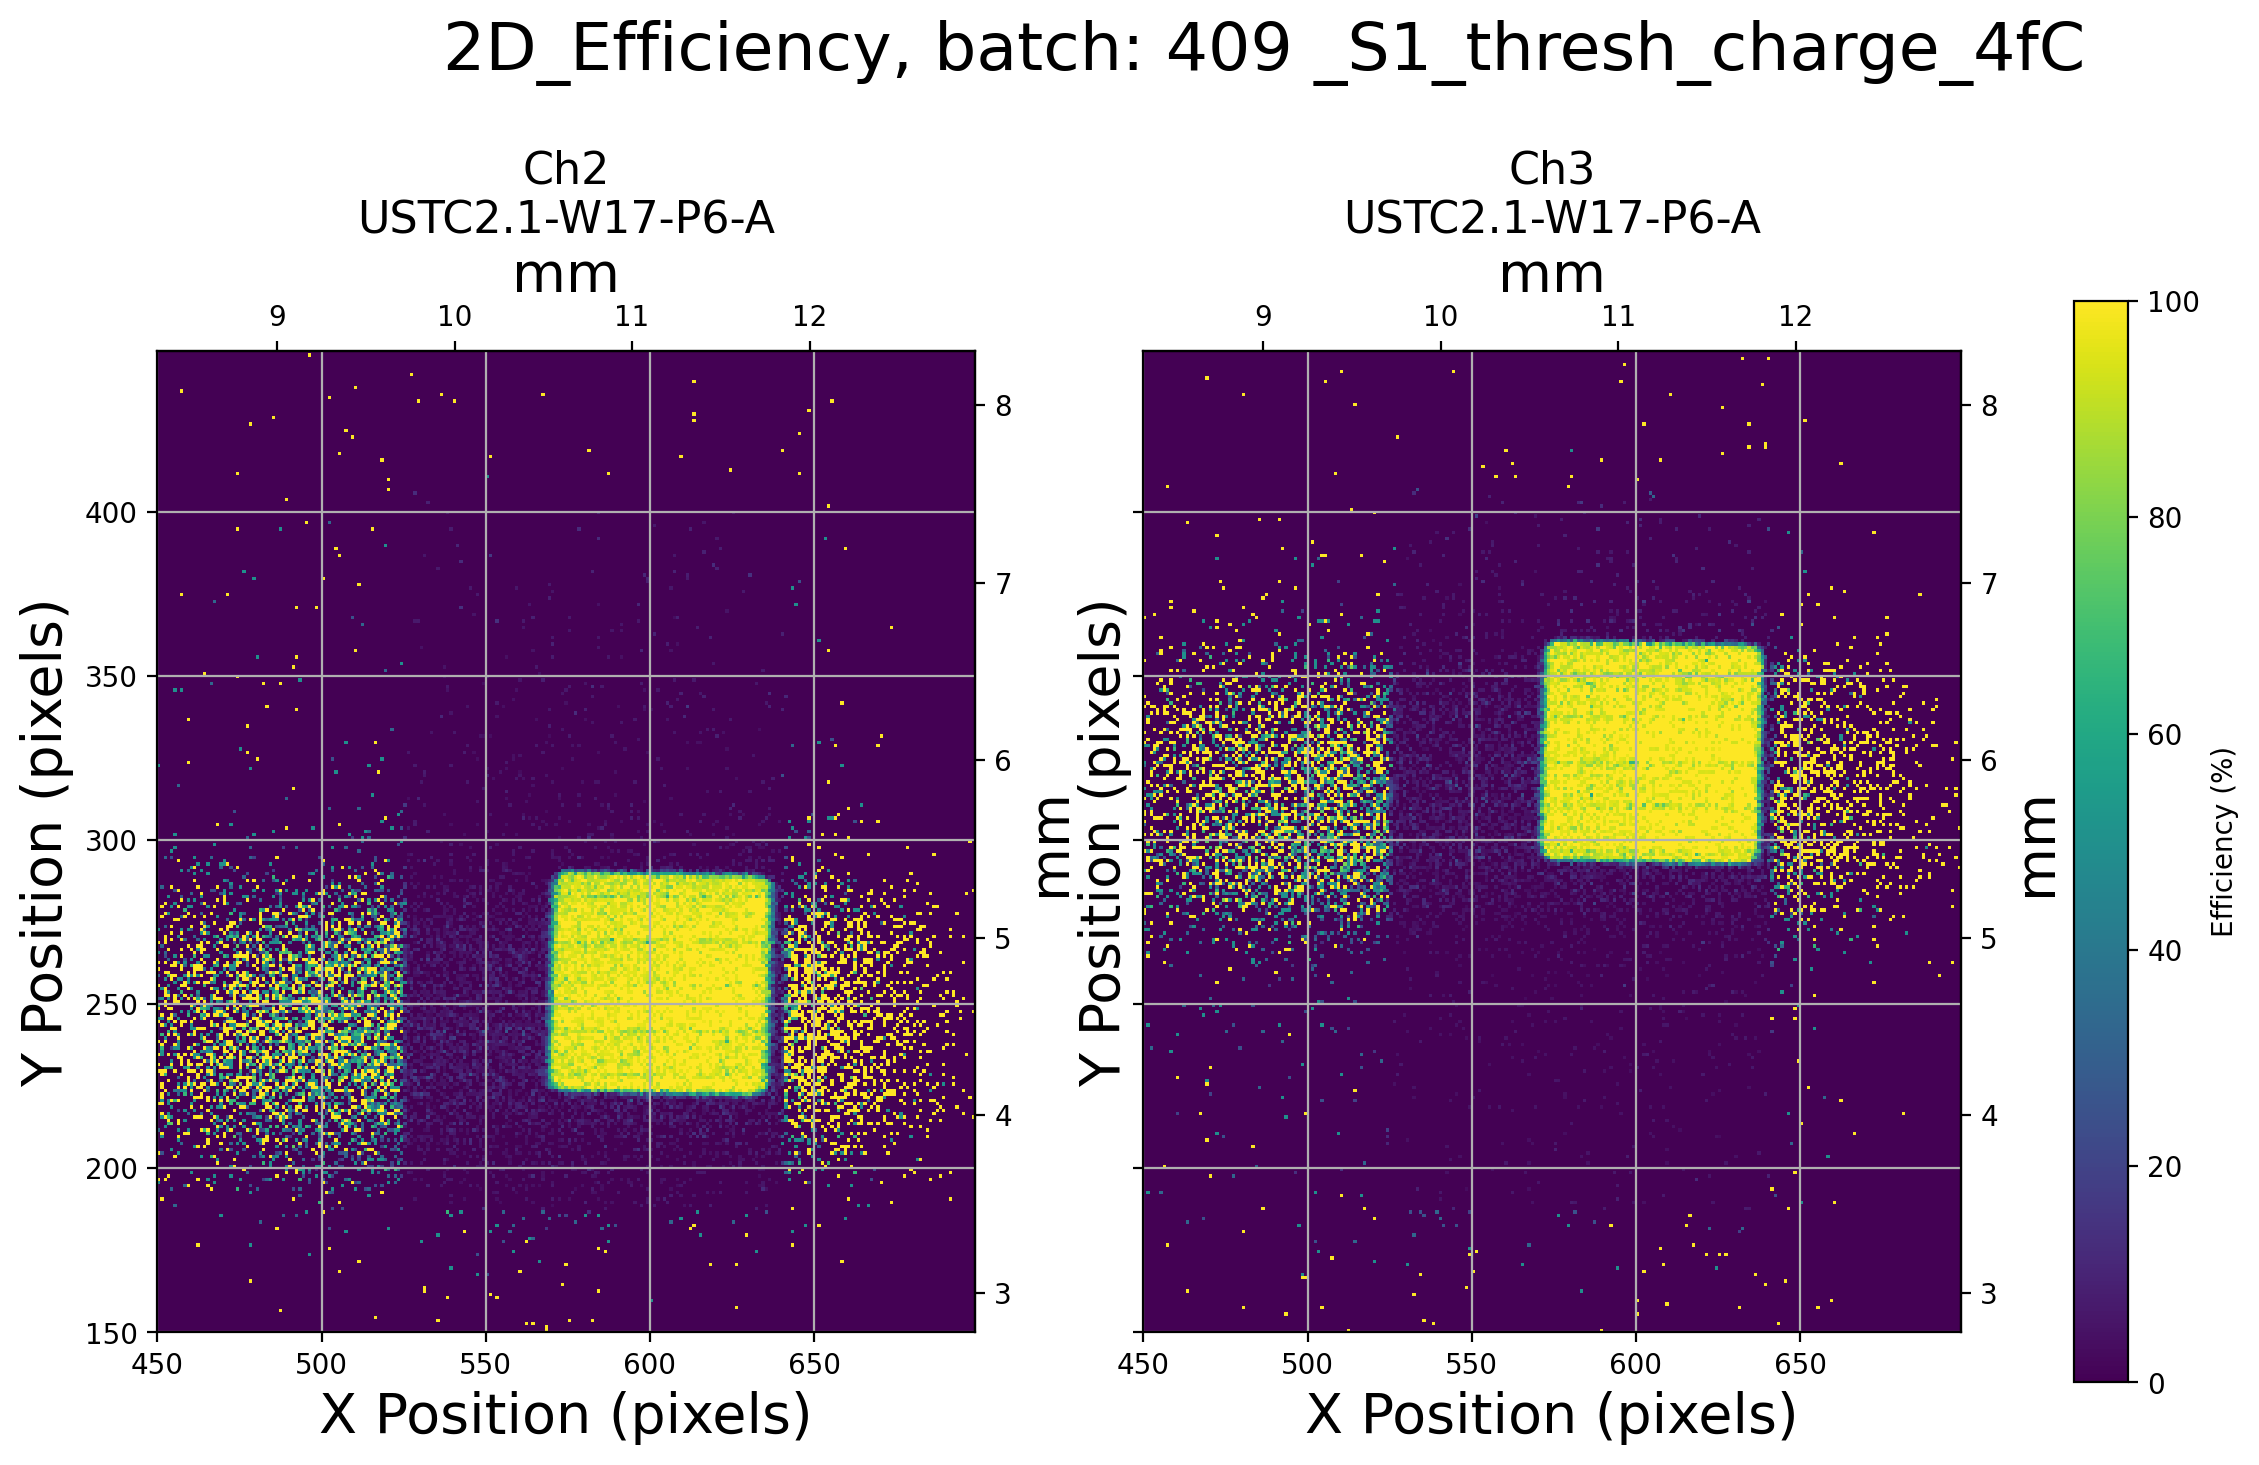

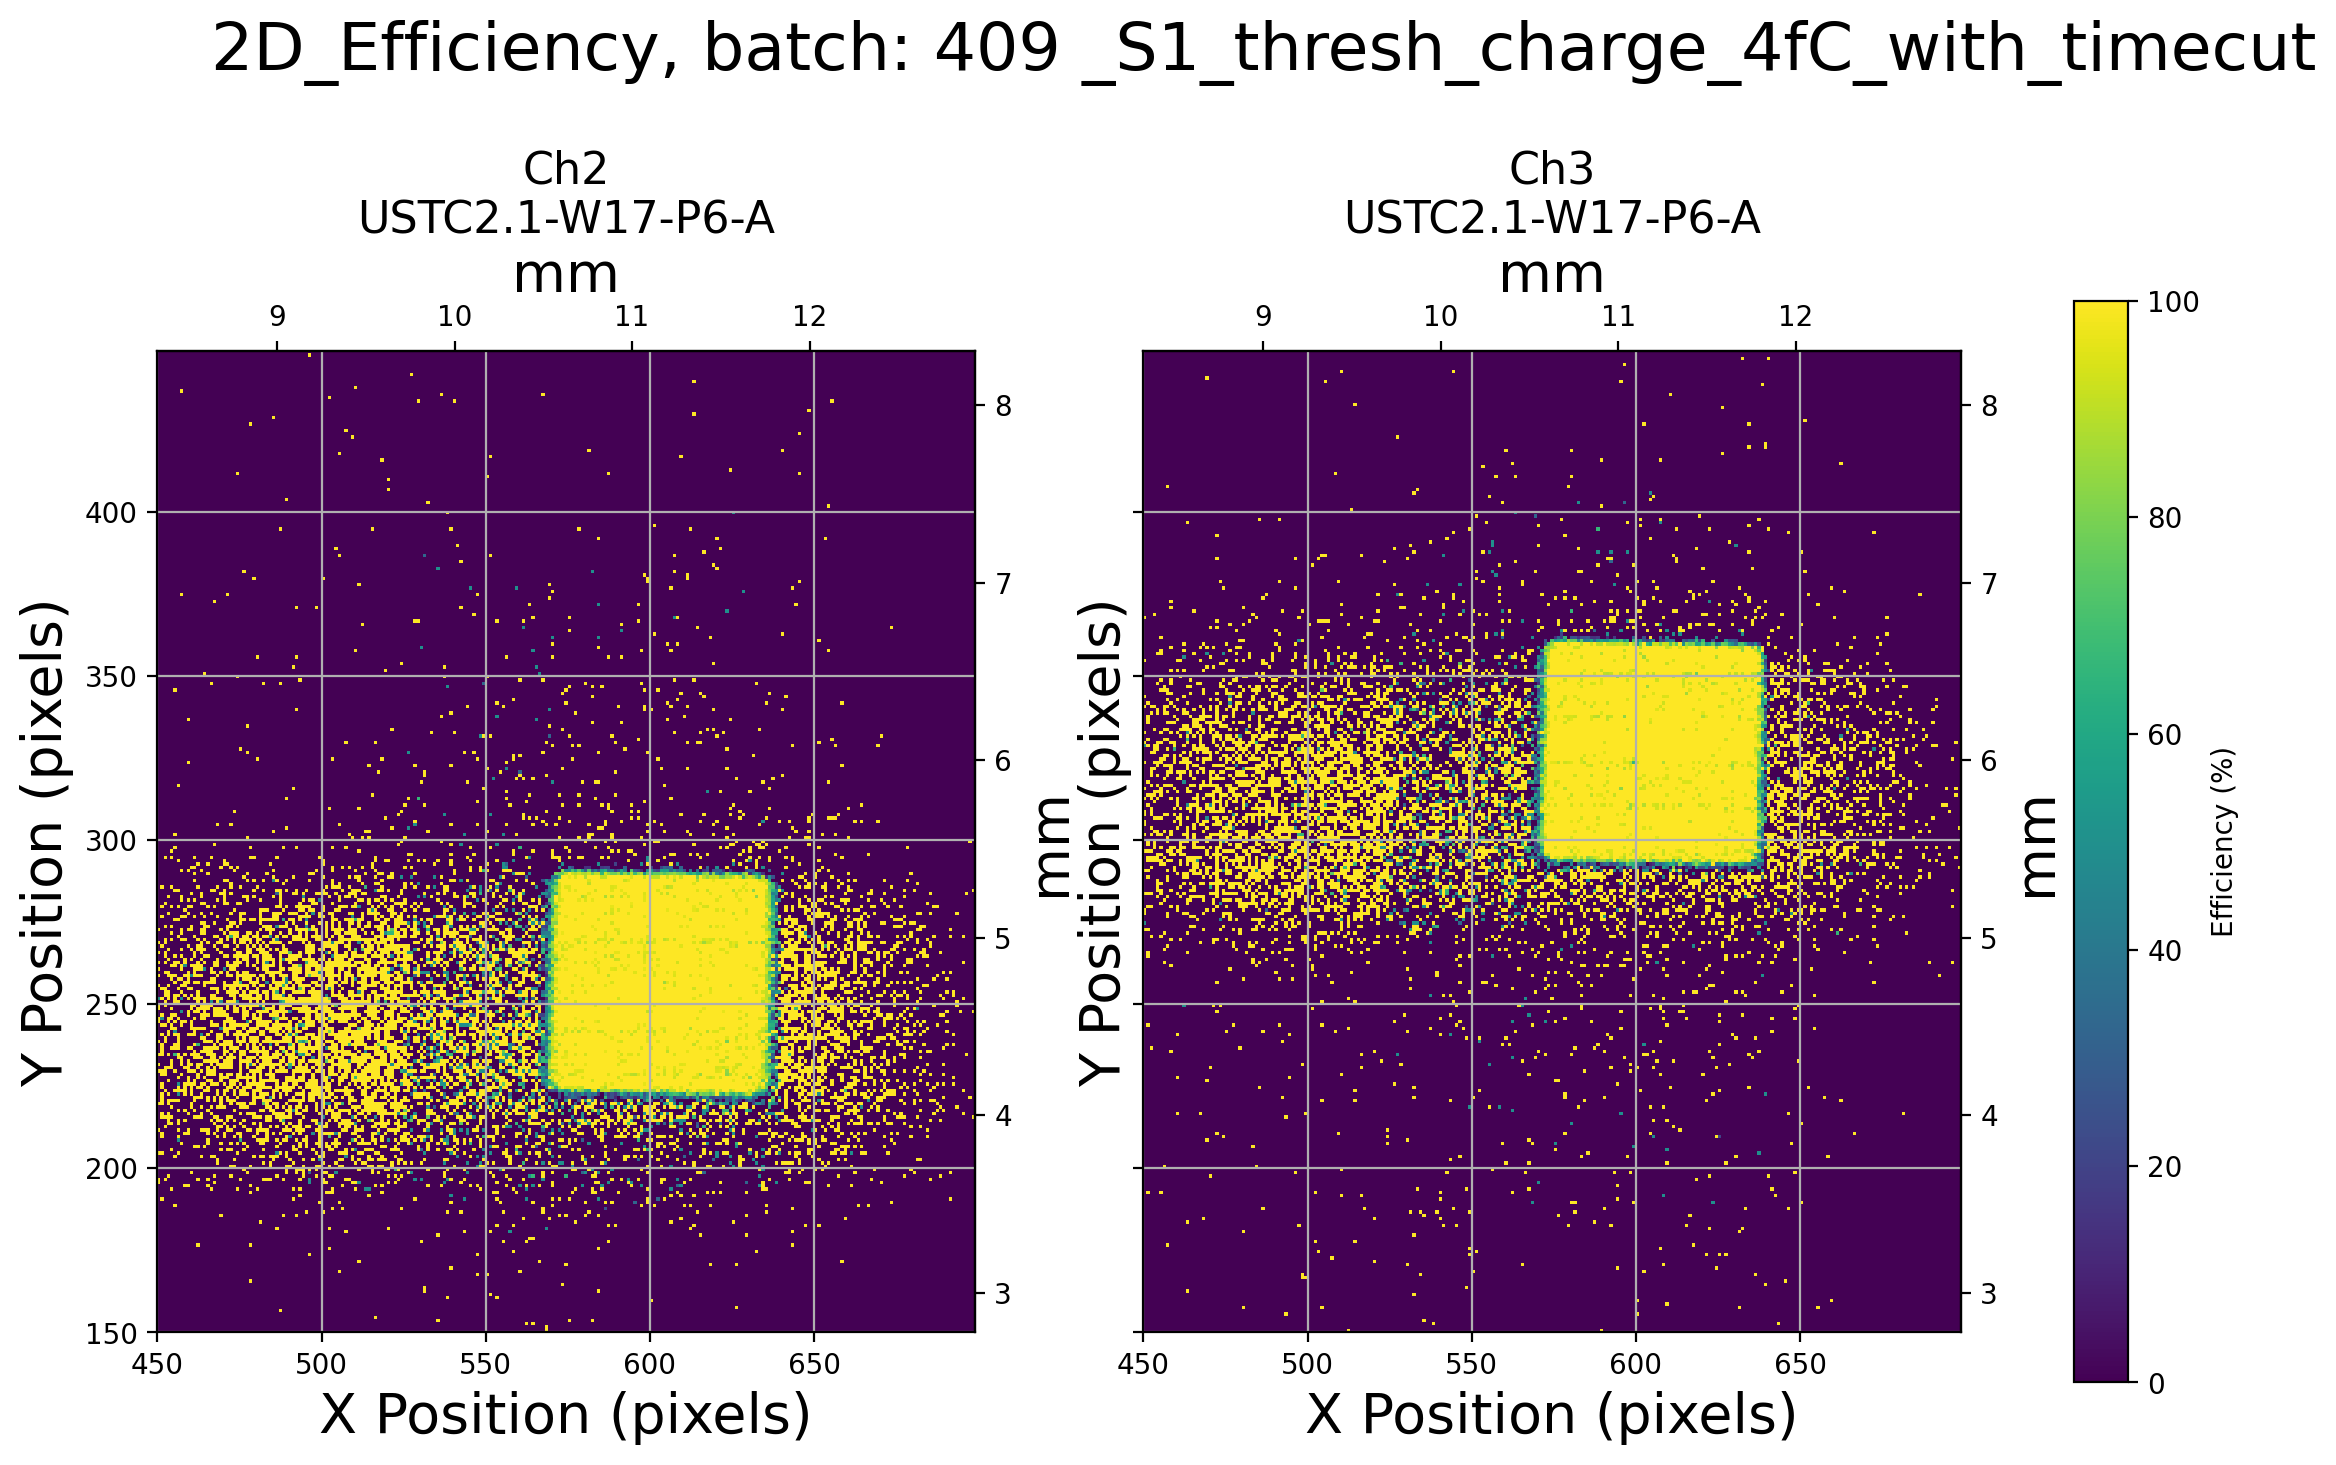

In [8]:
# %matplotlib inline
SAVE = False
for this_batch,S in batches_to_study:
    df = load_batch(this_batch,S)
    binning_method = 'rice'
    save_path = '../various plots/USTC_room_temp/'
#     os.mkdir(save_path)
    time_cut = [time_mask(df, i, plot=False)[0] for i in DUTs]
#     transimpedance = get_transimpedance(this_batch,S) ### this is still easier than extracting all the single values
    threshold_charge = 4 #fC
    #     print(f'angle: {dict_of_batches[this_batch].angle}°', f'temperature:{dict_of_batches[this_batch].tempA}°C')
    plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=bins1, bins_find_min=binning_method,
         n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}', fmt='jpg')
    
    plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC')
    
    plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, mask=time_cut,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_with_timecut')
#     plt.show()
    plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC')
    
    plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False, mask=time_cut,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_with_timecut')


In [9]:
# _,my_bins,_,fig,ax = plot_histogram(df['pulseHeight_1'],bins='rice')
# plot_histogram(df['pulseHeight_1'].loc[df['charge_1']>4], bins=my_bins, fig_ax=(fig,ax))
# plot_histogram(df['pulseHeight_1'].loc[time_cuts[0]], bins=my_bins, fig_ax=(fig,ax))
# ax.semilogy()

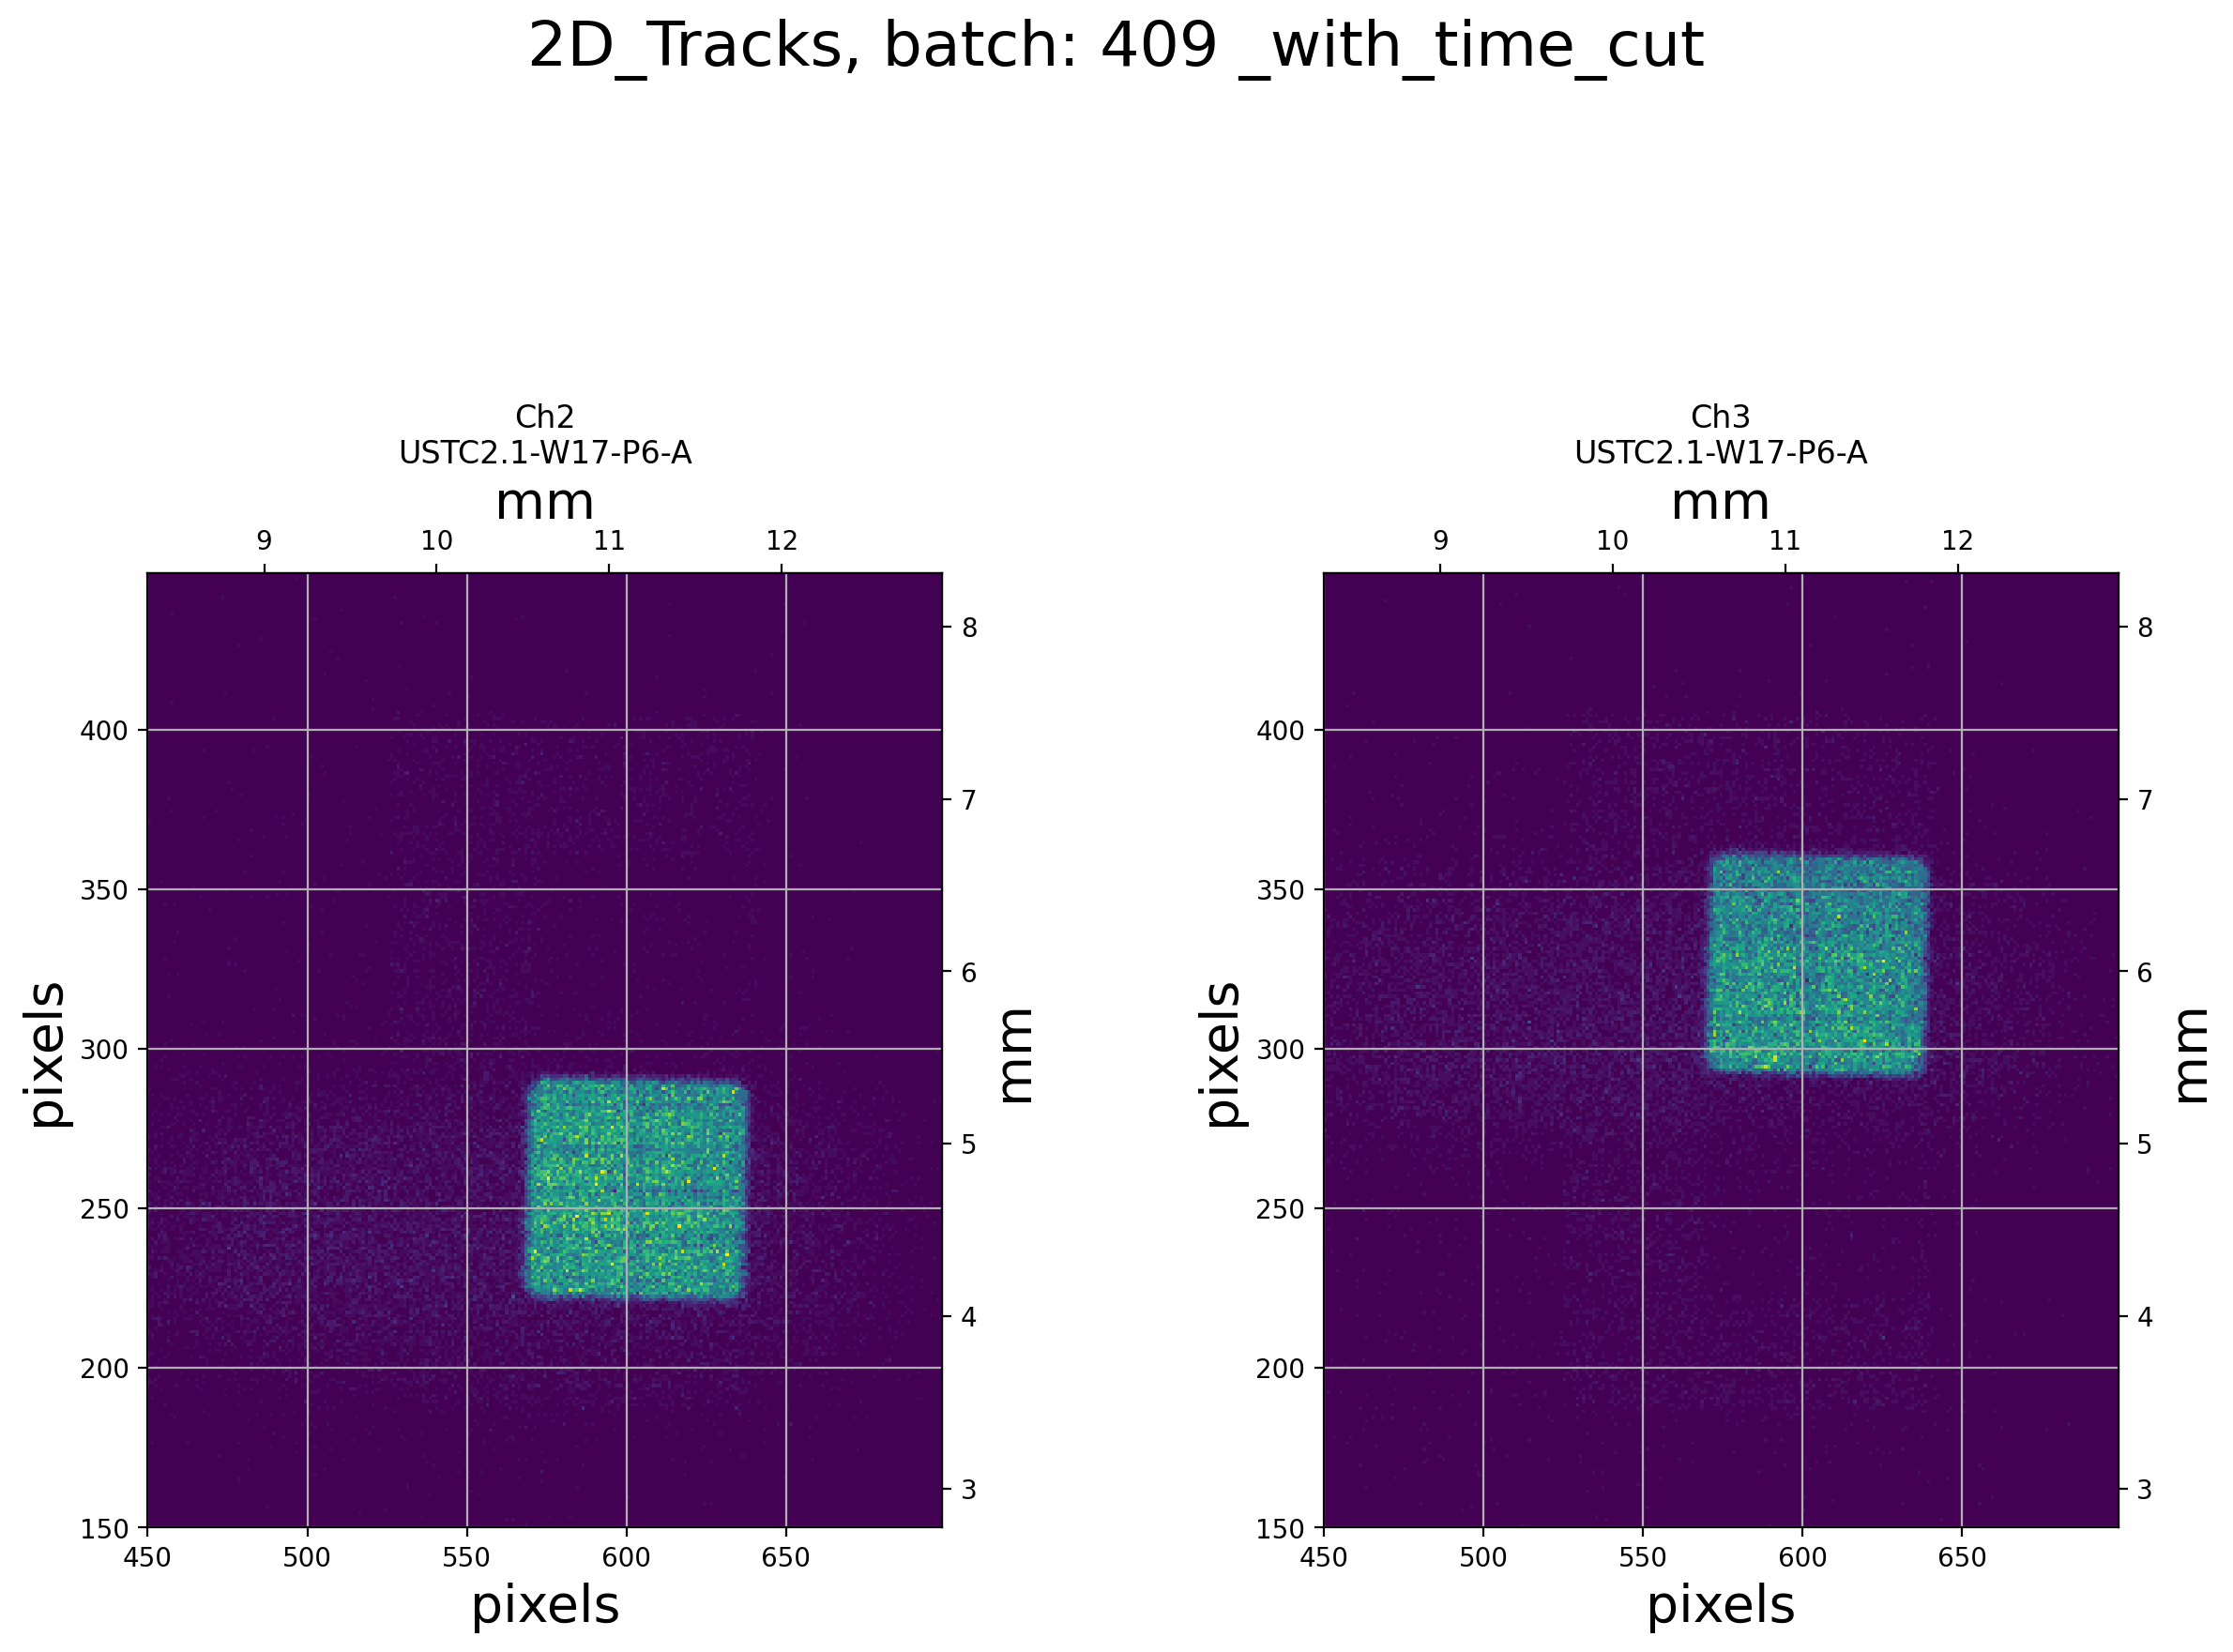

(<Figure size 2400x2000 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [10]:
S = 'S1'
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in (1,2)]
other_info = [time_mask(df, dut, bins=5000, plot=False)[1] for dut in (1,2)]
# time_cuts.insert(0,None)
plot(df, "2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], mask=time_cuts,
    savefig=True, savefig_details='_with_time_cut',fmt='jpg')

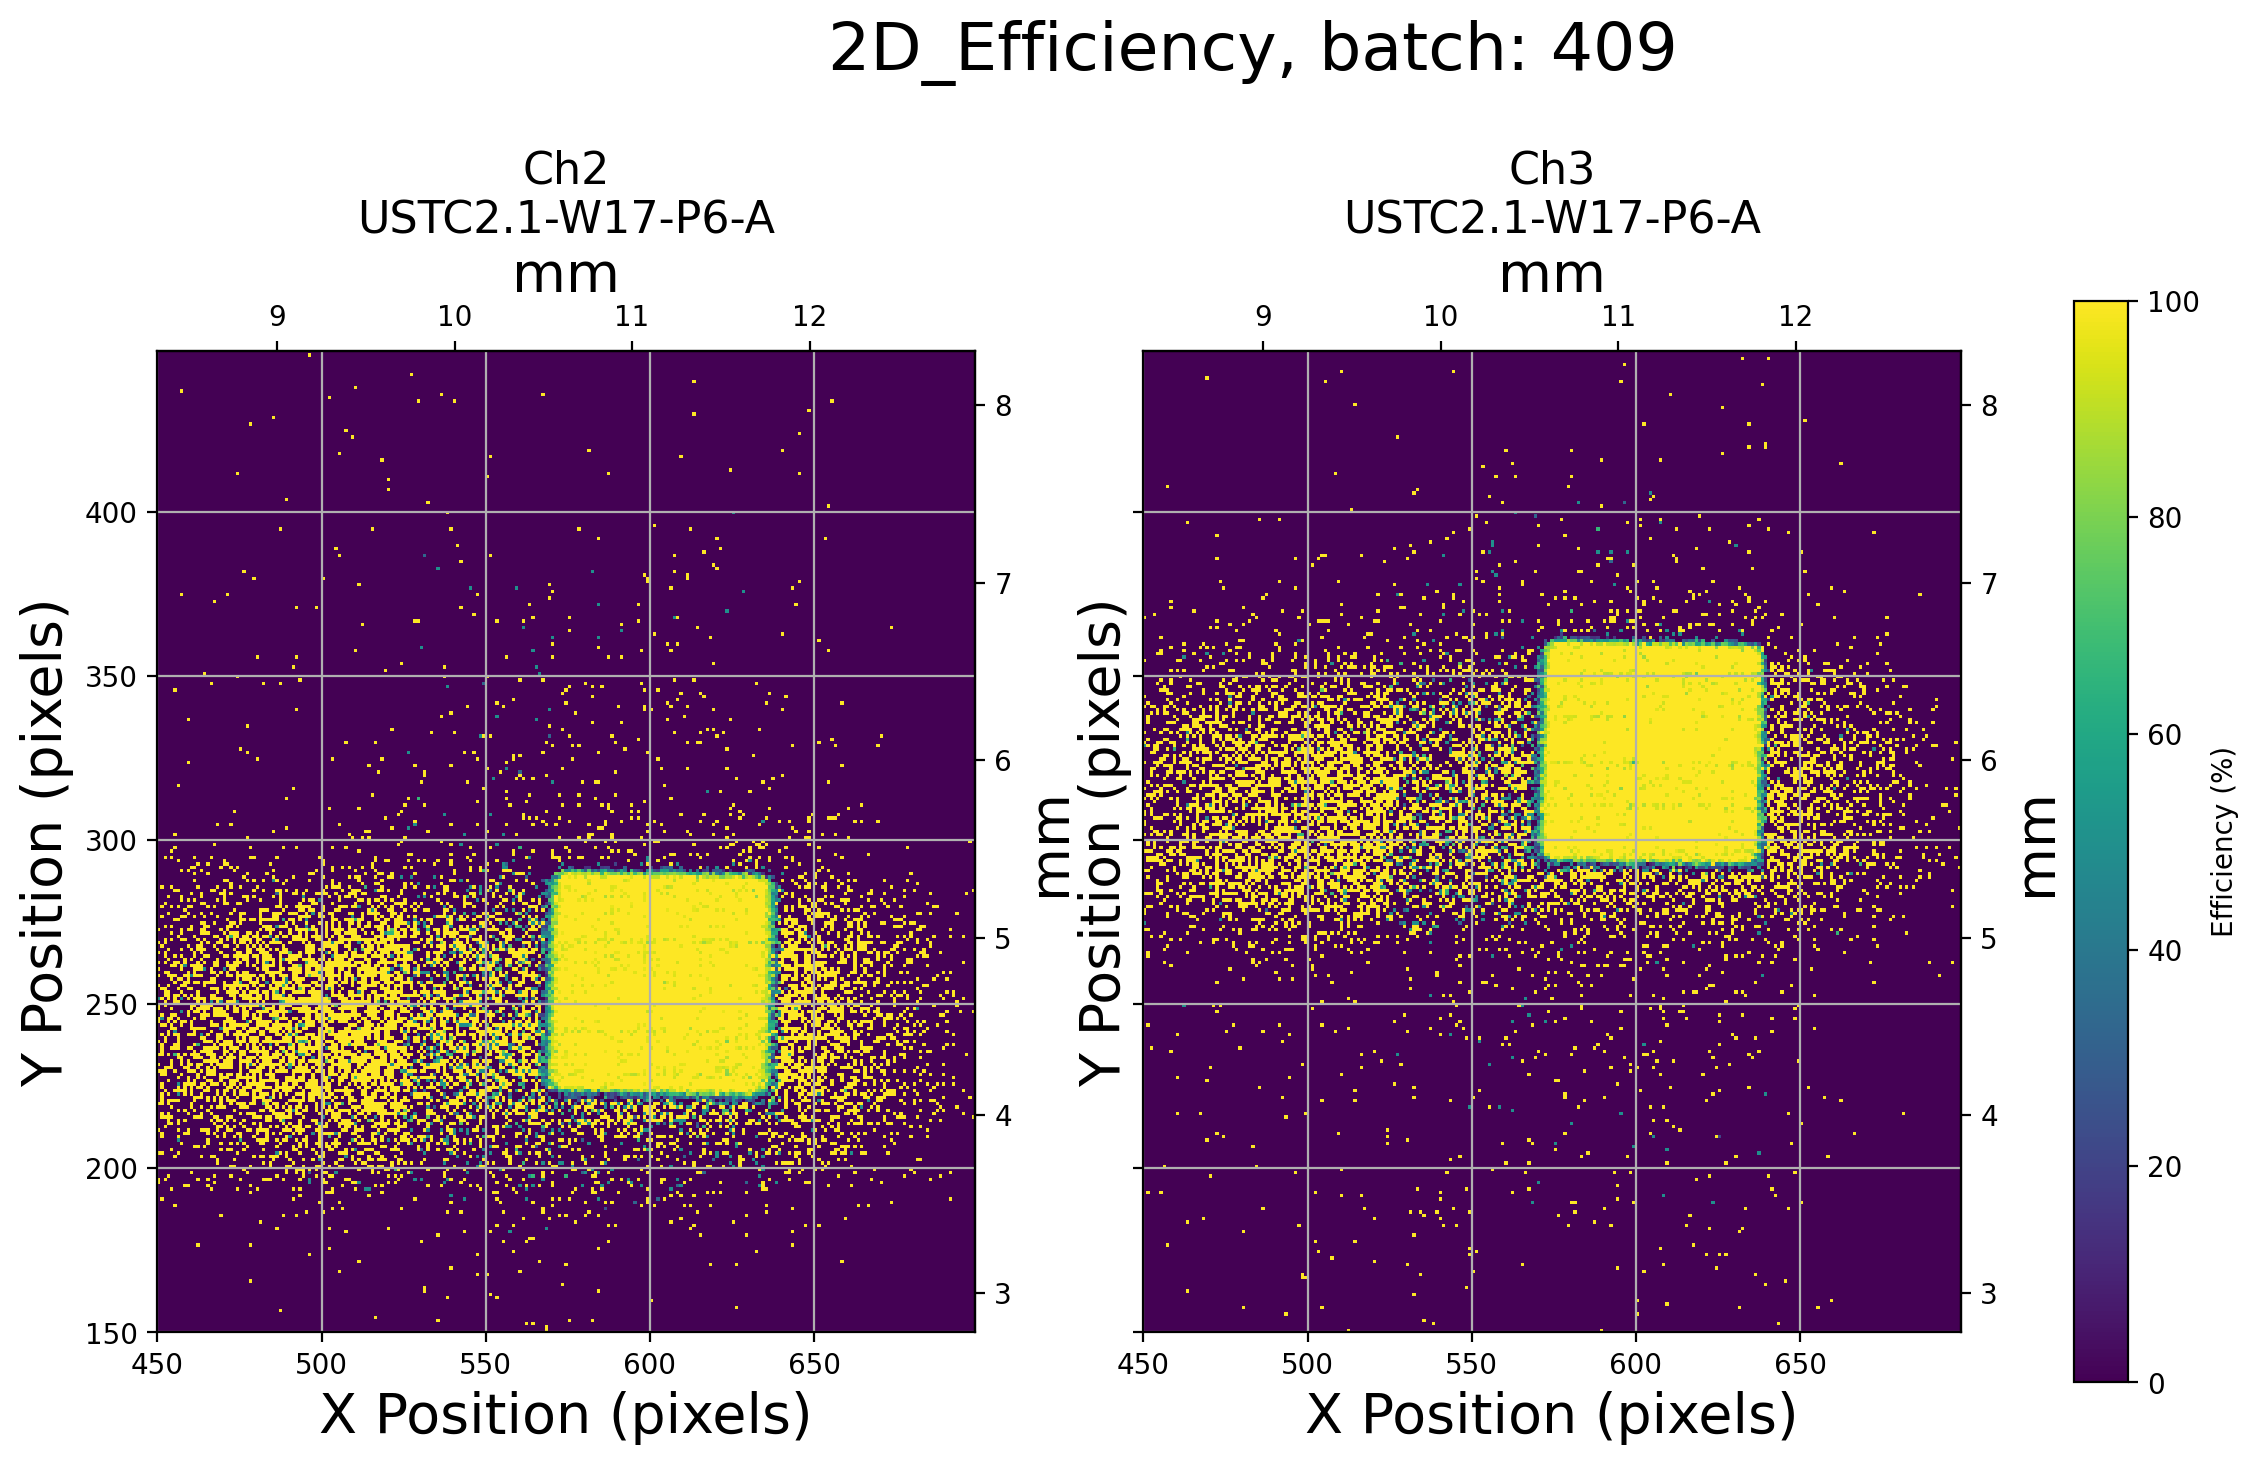

(<Figure size 2400x1200 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>,
        <AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>],
       dtype=object))

In [11]:
plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], threshold_charge=4,
     mask=time_cuts)

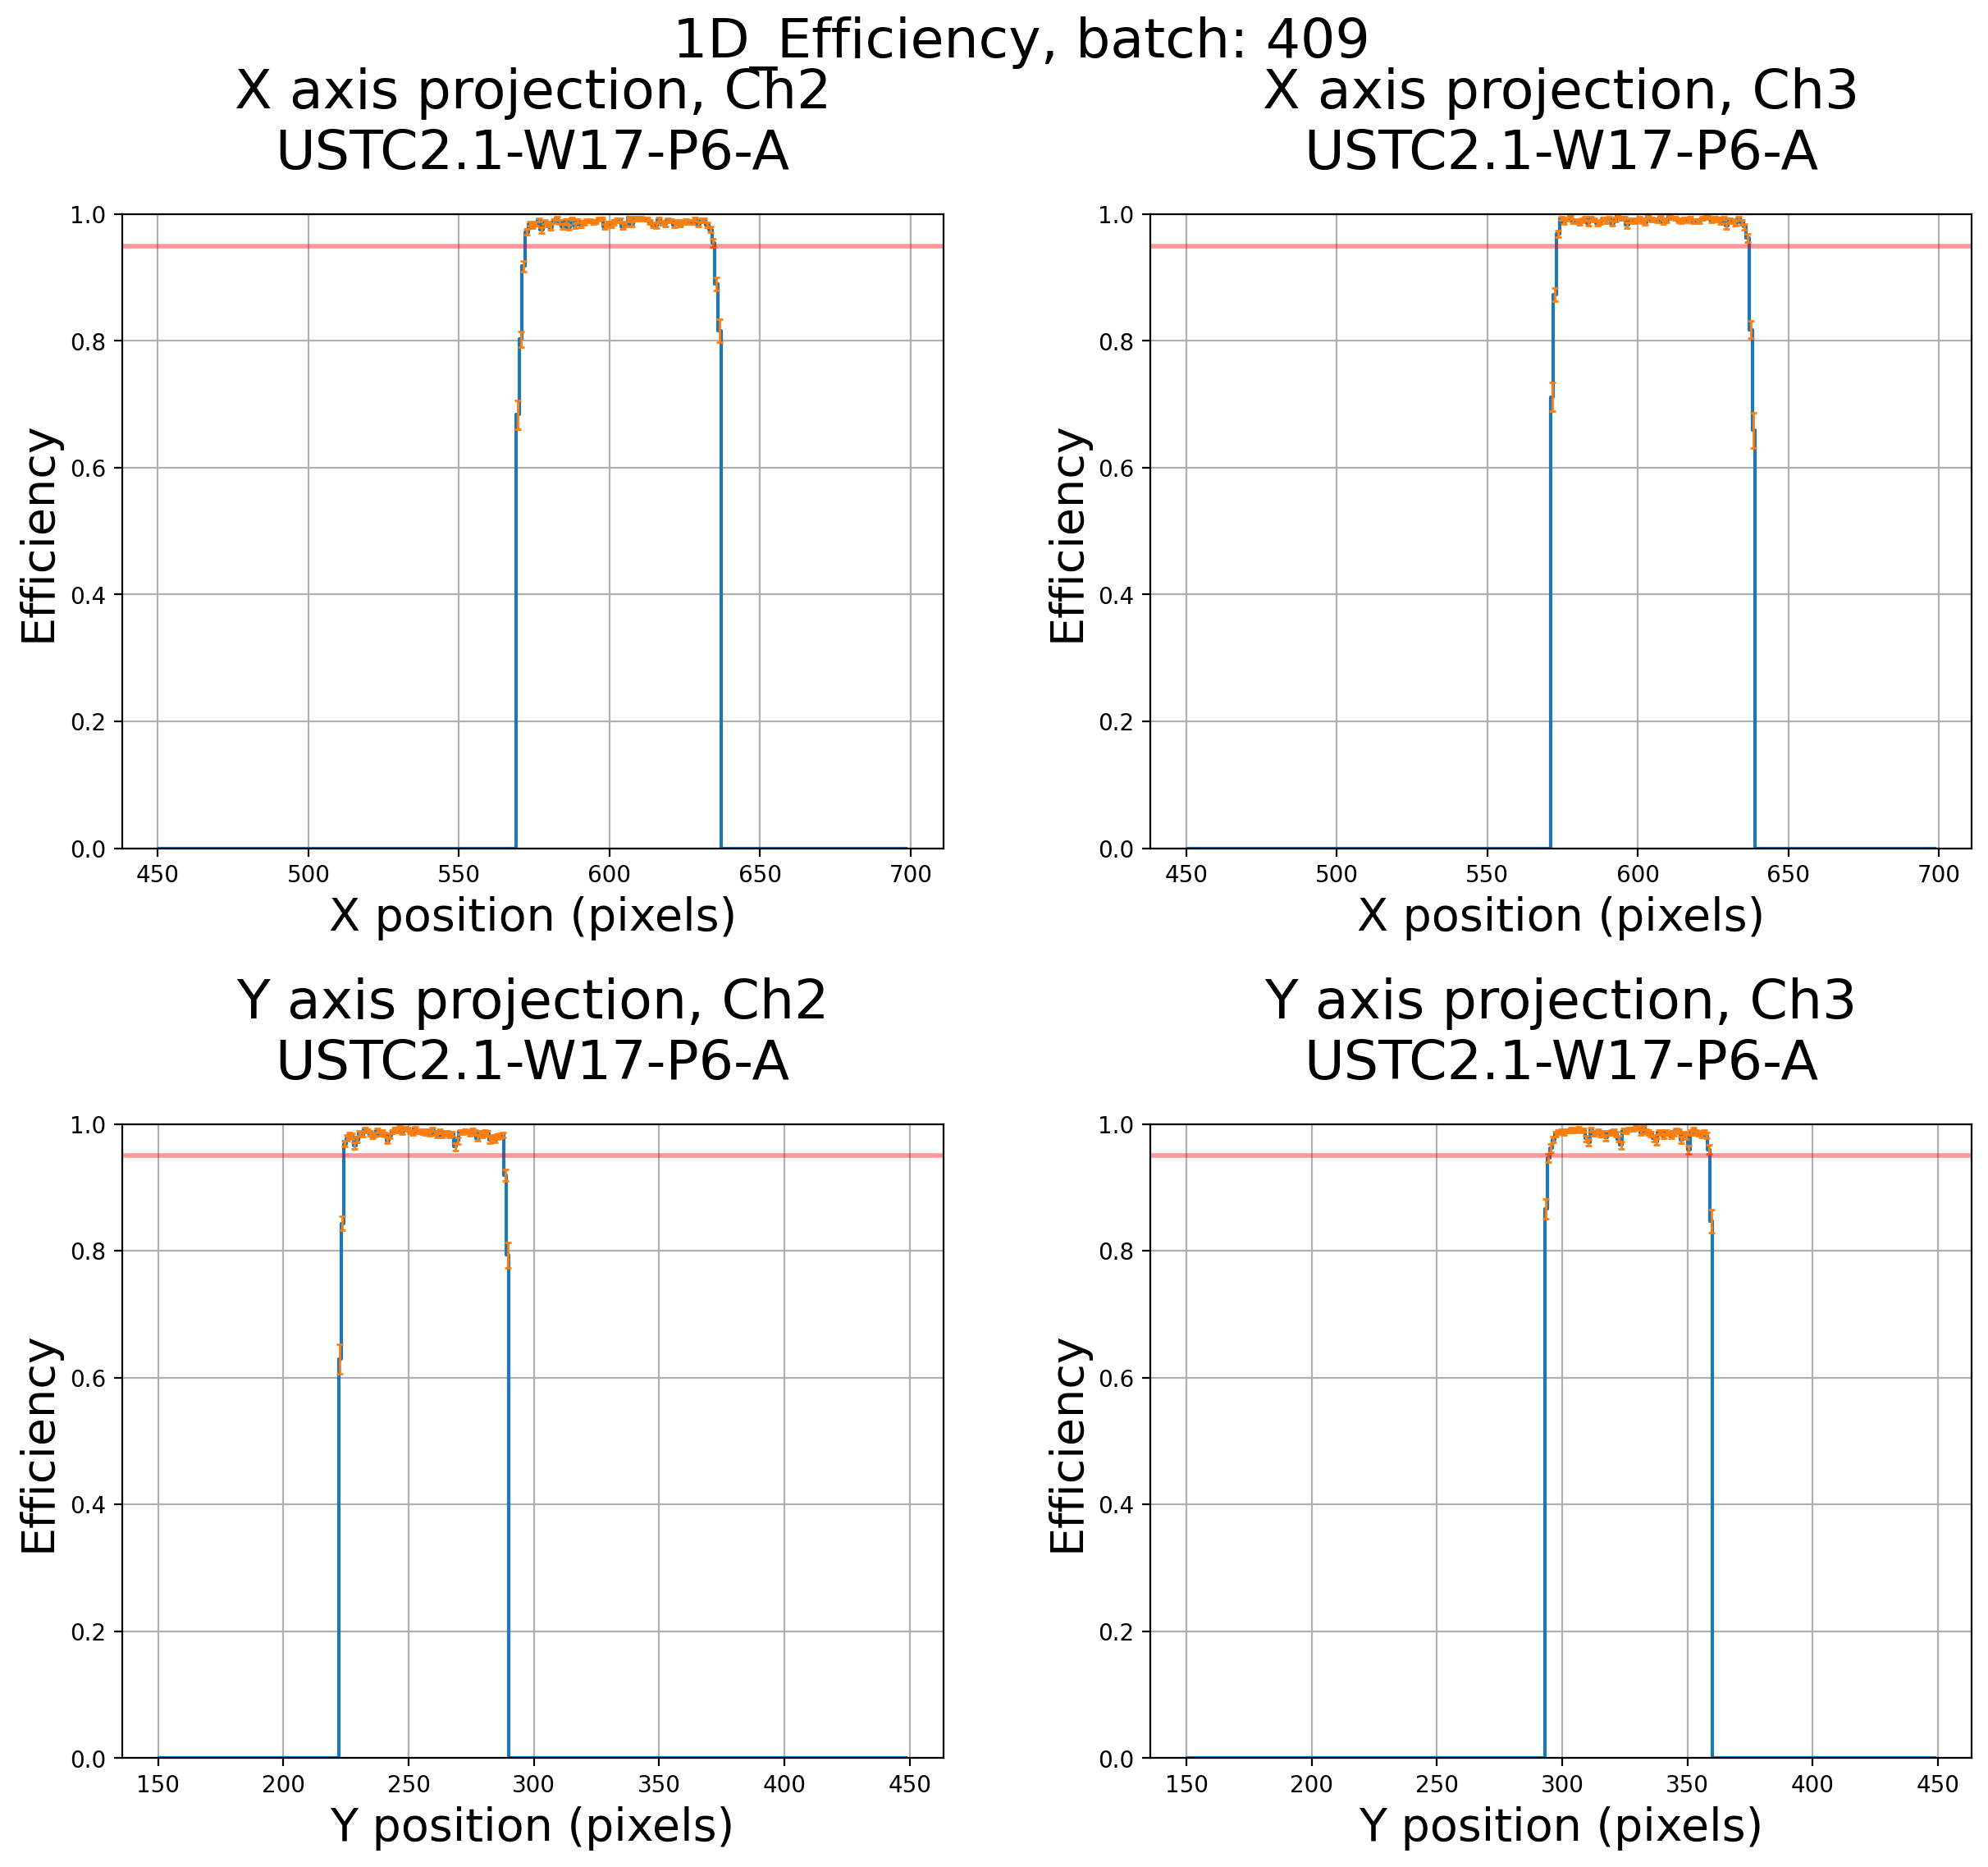

In [12]:
fig,ax = plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], threshold_charge=4,
             mask=time_cuts, geometry_cut=True)


In [13]:

print('Angled')
for batch_number,S,ch in USTC_dict['angled']:
    print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
    print('sensor angle:',dict_of_batches[batch_number].angle)
#     df = load_batch(batch_number, S)
    

Angled
Batch 411 MCP voltage: 2500
sensor angle: 13.0
Batch 411 MCP voltage: 2500
sensor angle: 13.0
Batch 412 MCP voltage: 2500
sensor angle: 13.0
Batch 412 MCP voltage: 2500
sensor angle: 13.0
Batch 413 MCP voltage: 2800
sensor angle: 6.0
Batch 413 MCP voltage: 2800
sensor angle: 6.0
Batch 414 MCP voltage: 2800
sensor angle: 6.0
Batch 414 MCP voltage: 2800
sensor angle: 6.0


## Charge plot

In [53]:
this_batch = 603
this_scope = 'S1'
df = load_batch(this_batch, S)


In [54]:
mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in DUTs]

### Plotting three different cuts (pulseHeight, geometric and time) and comparing them with each other
and now fitting with the charge too

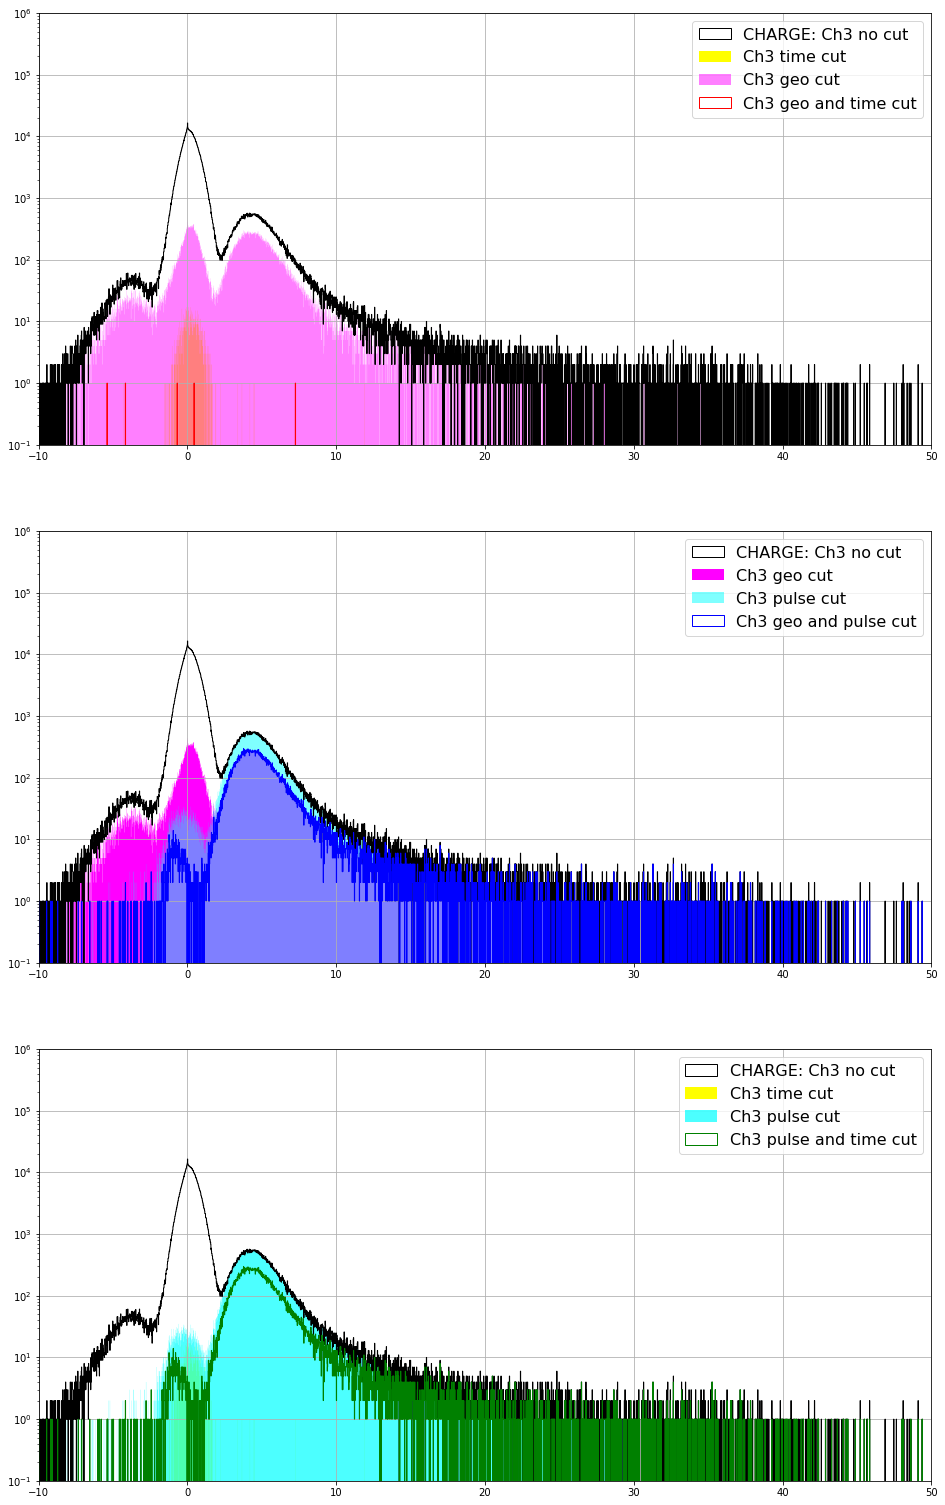

In [58]:
DO_FIT = False
### colors   0   1   2   3     4      5         6
colormap = ['k','r','g','b','cyan','yellow','magenta']
color_geo, color_pulse, color_time = 'magenta', 'cyan', 'yellow'

transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in DUTs]
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in DUTs]
geo_cuts = [geometry_mask(df, bins=bins1, bins_find_min='rice', DUT_number=dut) for dut in DUTs]
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] for dut in DUTs]
dut = 2

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,3*9))
for i in range(3):
    hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}']/transimpedance[dut-1], bins='auto',
                                          color=colormap[0], label=f"CHARGE: Ch{dut+1} no cut",
                                          fig_ax=(fig,axes[i]))
bins_centers = (my_bins[1:]+my_bins[:-1])/2
bins_centers = bins_centers.astype(np.float64)
legend_text = []
### --------------------------------
hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=0.5, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,axes[0]))

if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(10,1,1,np.max(hist_geo_time_cut)))
    axes[0].plot(bins_centers, pylandau.langau(bins_centers, *param),color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------
hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=1, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[1]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=0.5, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[1]))

hist_geo_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[3], alpha=1, label=f"Ch{dut+1} geo and pulse cut",
                                       fig_ax=(fig,axes[1]))
if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_pulse_cut, p0=(10,1,1,np.max(hist_geo_pulse_cut)))
    axes[1].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------

hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=.7, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[2], alpha=1, label=f"Ch{dut+1} pulse and time cut",
                                       fig_ax=(fig,axes[2]))

if DO_FIT:
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_pulse_time_cut, p0=(10,1,1,np.max(hist_pulse_time_cut)))
    axes[2].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")

for i in range(3):
    axes[i].semilogy()
    axes[i].set_xlim(-10,50)
    axes[i].set_ylim(0.1,1e6)
    handles, labels = axes[i].get_legend_handles_labels()
    if DO_FIT: handles.append(mpatches.Patch(color='none', label=legend_text[i]))
    axes[i].legend(handles=handles, fontsize=16);

# hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
#                                        histtype='stepfilled', alpha=0.5,
#                                        fig_ax=(fig,ax), label=f"CHARGE: Ch{dut+1} pulse cut")

In [66]:
def charge_fit(df, dut, mask, transimpedance, p0=None, plot=True):
    hist,my_bins,_,fig,ax = plot_histogram(df[f'charge_{dut}'].loc[mask]/transimpedance, bins='auto',
                                          label=f"CHARGE: Ch{dut+1} no cut")
    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)
    charge = bins_centers[np.argmax(hist)]
    logging.info(f'First charge estimate: {charge}')
    if p0 is None: p0 = (charge,1,1,np.max(hist))
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist, p0=p0)
    ax.plot(bins_centers, pylandau.langau(bins_centers, *param))
    if not plot: plt.close()
    return param, covariance

dut = 1
charge_fit(df, dut=dut, mask=np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1]), transimpedance=transimpedance[dut-1], plot=False)

/tmp/ipykernel_64734/350453101.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(bins_centers, pylandau.langau(bins_centers, *param))


(array([4.08267641e+00, 3.18811952e-01, 8.22351144e-01, 3.00717705e+03]),
 array([[ 9.98553852e-07, -3.83569765e-07,  4.29832313e-07,
          1.84489694e-05],
        [-3.83569765e-07,  1.93136958e-06, -2.16431319e-06,
         -9.28944219e-05],
        [ 4.29832313e-07, -2.16431319e-06,  3.59293248e-06,
         -1.36897030e-03],
        [ 1.84489694e-05, -9.28944219e-05, -1.36897030e-03,
          4.70895404e+00]]))

### Now I really need to automatically calculate the charge

/tmp/ipykernel_64734/1113230497.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")


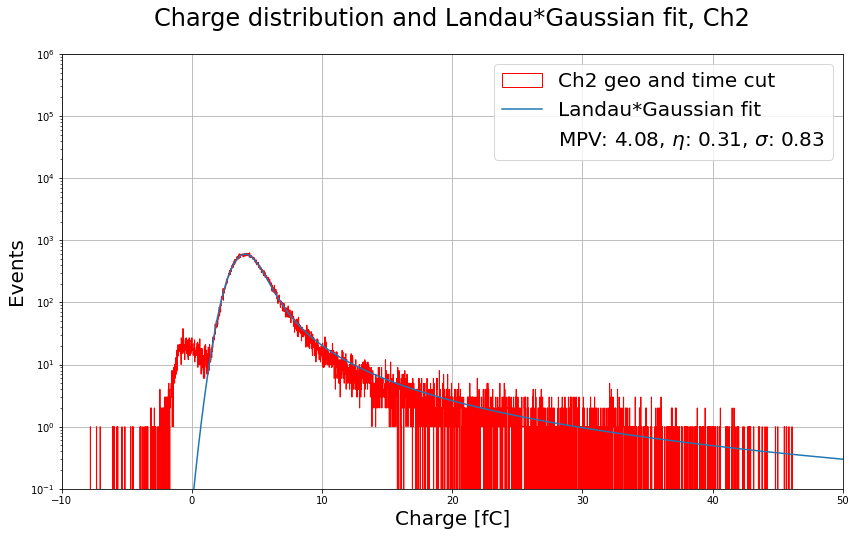

In [17]:
this_DUT = 1

fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')

hist_geo_time_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1]), bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,ax))

bins_centers = (my_bins[1:]+my_bins[:-1])/2
# bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(5,1,1,np.max(hist_geo_time_cut)))
# print(param) 
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()

ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
# fig.savefig(f"../various plots/Charge_distribution_fit_Ch2_{this_batch}.svg",bbox_inches='tight')
